In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Daily Service

In [ ]:
from tensorflow.keras.models import load_model

for crypto in cryptoes:
  model = load_model(f'models/{crypto["symbol"]}.h5')
  crypto['model'] = model


NameError: ignored

In [ ]:
import datetime
import pytz
import time

# get the start time
start_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
start_time = start_time - datetime.timedelta(hours=1)

DAYS_TO_RUN = 1
## Consider that we are running this for a day.
end_time = start_time + datetime.timedelta(days = DAYS_TO_RUN+1)

times = 0



start_date = '2022-07-27'
end_date = '2022-08-12'
for index, crypto in enumerate(cryptoes):
  m_df = get_csv(crypto['symbol'], start_date, end_date,'60')
  crypto['min'] = m_df.Close.min()
  crypto['max'] = m_df.Close.max()
  print(f'{crypto["symbol"]} : {crypto["min"]} - {crypto["max"]}')

  


while(datetime.datetime.now(tz=pytz.timezone('Asia/Tehran')) < end_time):
  for index, crypto in enumerate(cryptoes):
    #for crypto in cryptoes:
    symbol = crypto['symbol']
    print(symbol)
    ## Getting the data
    now_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
    if times == 0:
      new_df = get_csv_datetime(symbol,start_time, now_time ,'5')
    else:
      new_df = get_csv_datetime(symbol,now_time - datetime.timedelta(minutes=11), now_time ,'5')
    # Normalizing the data
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    new_df['Close'] = new_df['Close'].apply(lambda x: str(x).replace(',',''))
    new_df['Close'] = pd.to_numeric(new_df['Close'],errors='coerce')
    min = crypto['min']
    max = crypto['max']
    new_df.Close = (new_df.Close - min) / (max - min)

    if len(new_df) < 4:

      crypto['df'].loc[-1] = new_df.loc[0]
      crypto['df'].index = crypto['df'].index + 1
      crypto['df'] = crypto['df'].sort_index()
    else:
      crypto['df'] = new_df
    ## Windowing the df
    windowed_df = window_dataframe(crypto['df'],'1999-1-1','2090-1-1',4)
    dates, X,y = windowed_df_to_date_X_y(windowed_df)
    crypto['dates'] = dates
    crypto['X'] = X
    crypto['y'] = y

  
  fig = plt.figure(figsize=(26,12))
  fig.suptitle(f'{now_time.hour}:{now_time.minute}')
  axes = fig.subplots(nrows=3,ncols=3)
  for index, crypto in enumerate(cryptoes):
      ax = axes[int(index/3)][index%3]
      y_preds = crypto['model'].predict(crypto['X']).flatten()
      idx = np.argwhere(np.diff(np.sign(crypto['y'] - y_preds))).flatten()

      ax.set_title(crypto['symbol'])

      min = crypto['min']
      max = crypto['max']
      
      signals = []
      for id in idx:
        price = crypto['y'][id] * (max-min) + min
        time_str = f'{crypto["dates"][id].hour}:{crypto["dates"][id].minute}' 
        if id+1 < len(crypto['y']):
          if crypto['y'][id] < y_preds[id]:
            signals.append({'type':'buy','time':time_str, 'price':price})
          elif crypto['y'][id] > y_preds[id]:
            signals.append({'type':'sel','time':time_str, 'price':price})
          else:
            if crypto['y'][id] < crypto['y'][id+1]:
              signals.append({'type':'buy','time':time_str, 'price':price})
            elif crypto['y'][id] > crypto['y'][id+1]:
              signals.append({'type':'sel','time':time_str, 'price':price})
      

      
      if times == 0:
        crypto['signals'] = signals  
        print(f'signals {crypto["symbol"]}: {signals}')
      else:
        len_new =  len(signals) - len(crypto['signals'])
        if len_new > 0:
          new_signals = signals[(-1) * len_new:]
          for signal in new_signals:
            signal['time'] = f'{crypto["dates"][-1].hour}:{crypto["dates"][-1].minute}' 
            signal['price'] = crypto['y'][-1] * (max-min) + min
          print(f'new signals {crypto["symbol"]}: {new_signals}')

        crypto['signals'] = signals
      

      ax.plot(crypto['dates'], y_preds)

      ax.plot(crypto['dates'],crypto['y'])
      ax.plot(dates[idx], crypto['y'][idx], 'ro' )
      ax.legend(['Predicted Price','Actual Price'])
  
  times+=1
  plt.show()
  print('----------------------------------------------------------------------------------------------------------------------------------------------')
  for crypto in cryptoes:
    print(f'signals {crypto["symbol"]}: {crypto["signals"]}')
  time.sleep(300)



In [ ]:
signal_list = {}
for crypto in cryptoes:
  signal_list[crypto['symbol']] = crypto['signals']
signal_list


calculate_profit(signal_list)

{'ADAIRT': {'profits': [], 'total-profit': 0},
 'DOTIRT': {'profits': [], 'total-profit': 0},
 'EOSIRT': {'profits': [0, 0, 0], 'total-profit': 0},
 'ETHIRT': {'profits': [], 'total-profit': 0},
 'LINKIRT': {'profits': [], 'total-profit': 0},
 'SANDIRT': {'profits': [0], 'total-profit': 0},
 'TRXIRT': {'profits': [], 'total-profit': 0},
 'UNIIRT': {'profits': [0, 0, 0, 0, 0, 0], 'total-profit': 0},
 'XRPIRT': {'profits': [0, 0, 0, 0, 0, 0], 'total-profit': 0},
 'total': 0}

In [ ]:
!pip install python-telegram-bot --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 513 kB 2.3 MB/s 
     |████████████████████████████████| 423 kB 62.5 MB/s 
     |████████████████████████████████| 58 kB 8.6 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0, but you have tornado 6.2 which is incompatible.


In [ ]:
import telegram

#Final Code .py -- 5 minutes time frame

TRXIRT : 2126.0 - 2291.0
ADAIRT : 15100.0 - 17369.0
LINKIRT : 203681.0 - 292999.0
EOSIRT : 35852.0 - 45863.0
ETHIRT : 46980000.0 - 60200000.0
XRPIRT : 10874.0 - 12979.0
DOTIRT : 218500.0 - 297000.0
UNIIRT : 213000.0 - 306229.0
SANDIRT : 37796.0 - 44990.0
TRXIRT
                        Date     Close    Open    High     Low
0  2022-08-14 09:45:00+04:30 -0.133333  2121.0  2126.0  2121.0
1  2022-08-14 09:40:00+04:30 -0.151515  2121.0  2126.0  2121.0
2  2022-08-14 09:35:00+04:30 -0.127273  2122.0  2124.0  2122.0
3  2022-08-14 09:30:00+04:30 -0.054545  2128.0  2129.0  2128.0
4  2022-08-14 09:25:00+04:30 -0.084848  2117.0  2119.0  2117.0
5  2022-08-14 09:20:00+04:30  0.054545  2111.0  2121.0  2111.0
6  2022-08-14 09:15:00+04:30 -0.084848  2112.0  2140.0  2112.0
7  2022-08-14 09:10:00+04:30 -0.054545  2134.0  2134.0  2134.0
8  2022-08-14 09:05:00+04:30 -0.018182  2113.0  2118.0  2113.0
9  2022-08-14 09:00:00+04:30 -0.036364  2111.0  2117.0  2111.0
10 2022-08-14 08:55:00+04:30 -0.024242  2105.

lost signals ETHIRT: []


lost signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}]
lost signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.0010547638}, {'type': 'buy', 'time': '9:25', 'price': 281549.9980151653}, {'type': 'sel', 'time': '9:40', 'price': 281549.9980151653}]
lost signals UNIIRT: []
lost signals SANDIRT: []


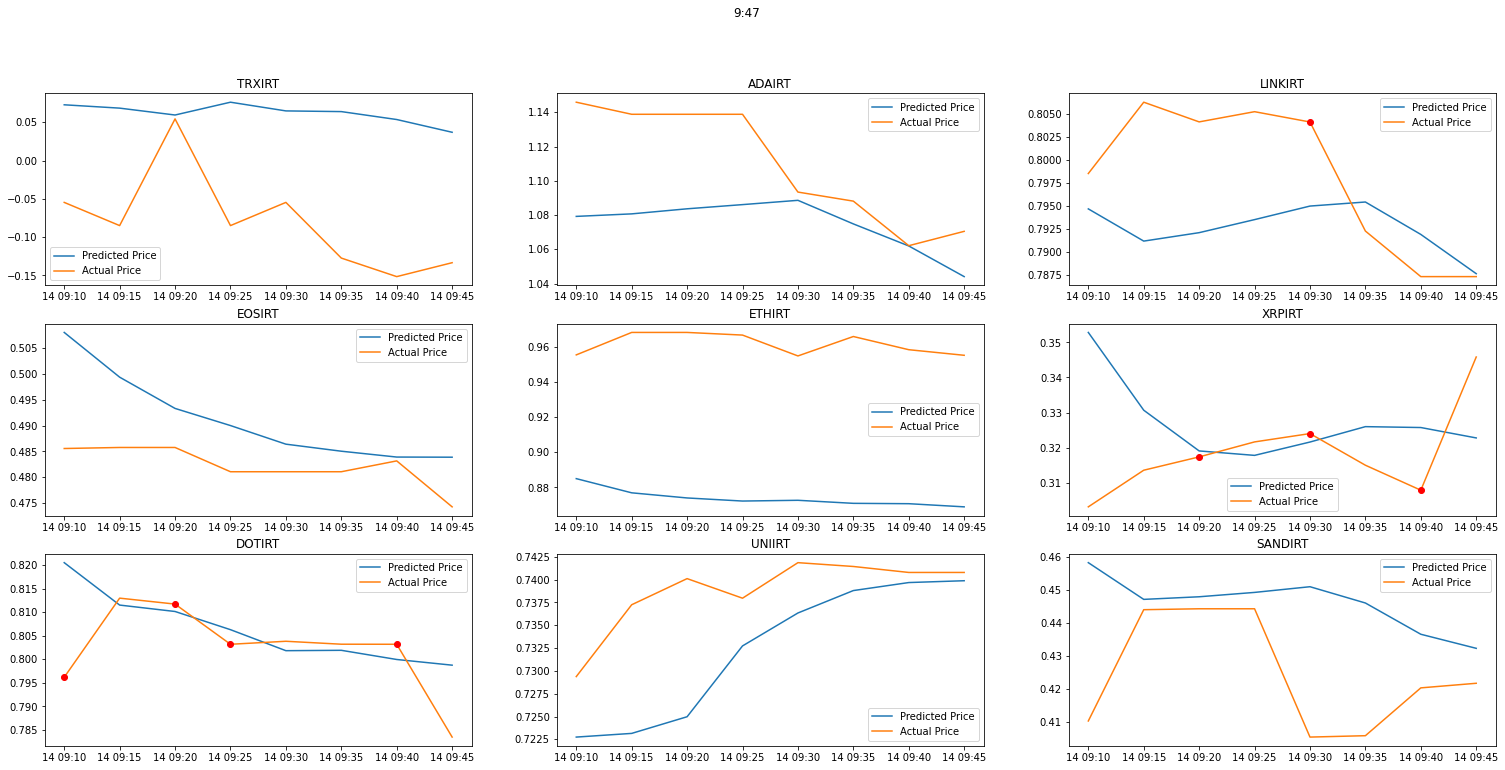

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}]
signals EOSIRT: []
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}]
signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.0010547638}, {'type': 'buy', 'time': '9:25', 'price': 281549.9980151653}, {'type': 'sel', 'time': '9:40', 'price': 281549.9980151653}]
signals UNIIRT: []
signals SANDIRT: []
TRXIRT
ADAIRT
LINKIRT
EOSIRT
ETHIRT
XRPIRT
DOTIRT
UNIIRT
SANDIRT
new signals XRPIRT: [{'type': 'sel', 'time': '9:50', 'price': 11504.999973267317}]
new signals DOTIRT: [{'type': 'buy', 'time': '9:50', 

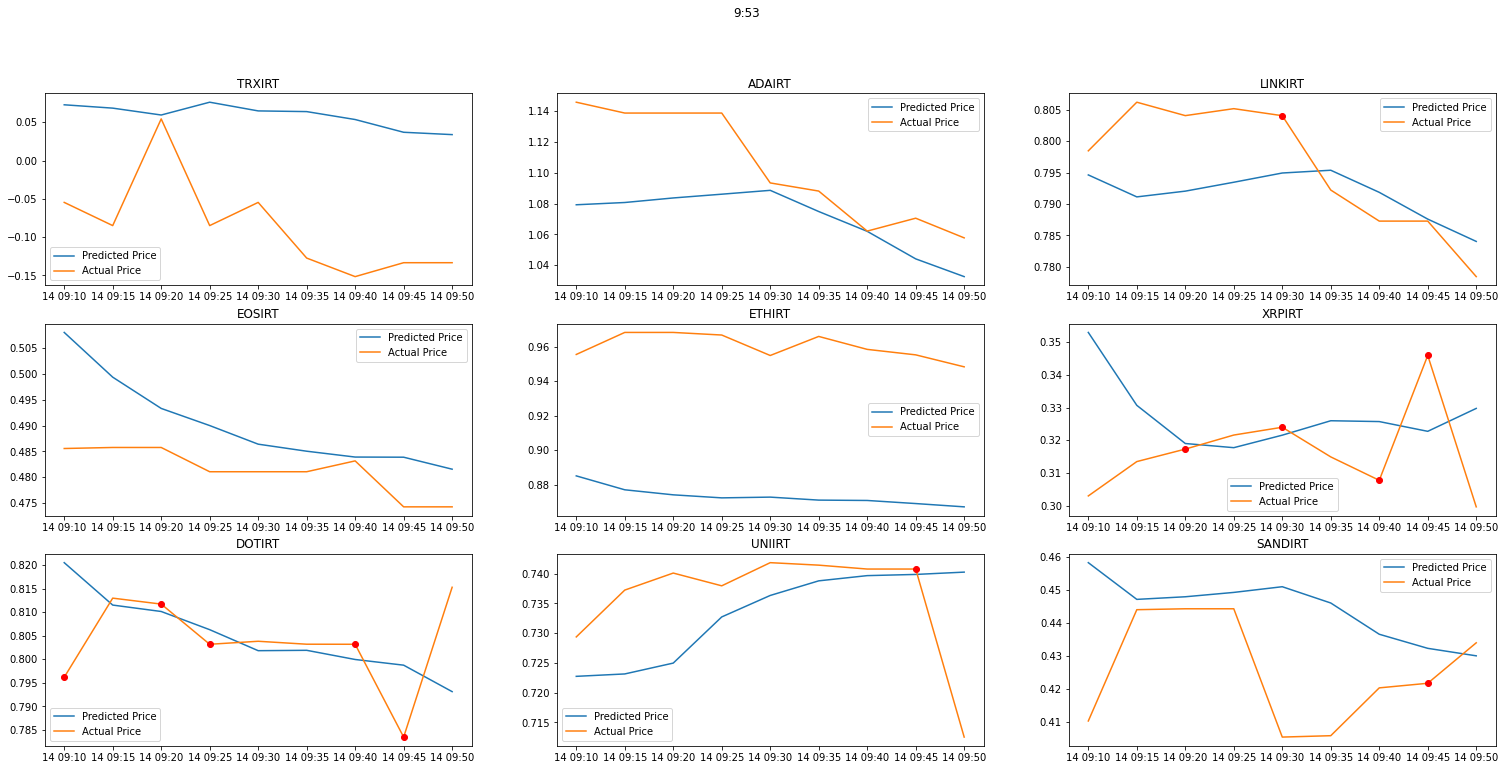

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}]
signals EOSIRT: []
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:50', 'price': 11504.999973267317}]
signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.0010547638}, {'type': 'buy', 'time': '9:25', 'price': 281549.9980151653}, {'type': 'sel', 'time': '9:40', 'price': 281549.9980151653}, {'type': 'buy', 'time': '9:50', 'price': 282498.99965524673}]
signals UNIIRT: [{'type': 'sel', 'time': '9:50', 'price': 279428.9999629855}]
signals SANDIRT: [{'type': 'buy', 'tim

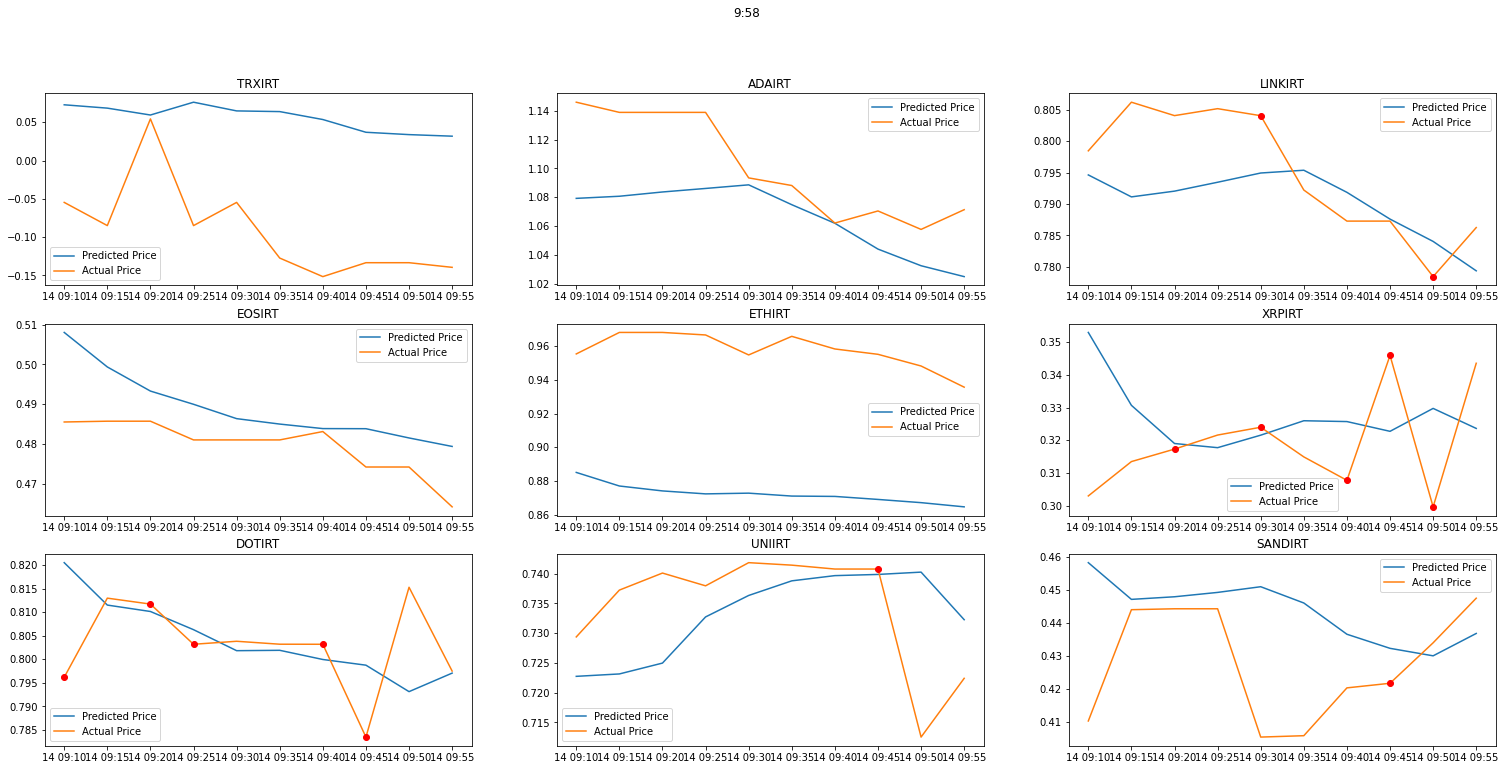

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:55', 'price': 273908.0011065006}]
signals EOSIRT: []
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:55', 'price': 11596.999973744154}]
signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.0010547638}, {'type': 'buy', 'time': '9:25', 'price': 281549.9980151653}, {'type': 'sel', 'time': '9:40', 'price': 281549.9980151653}, {'type': 'buy', 'time': '9:45', 'price': 280004.9992203

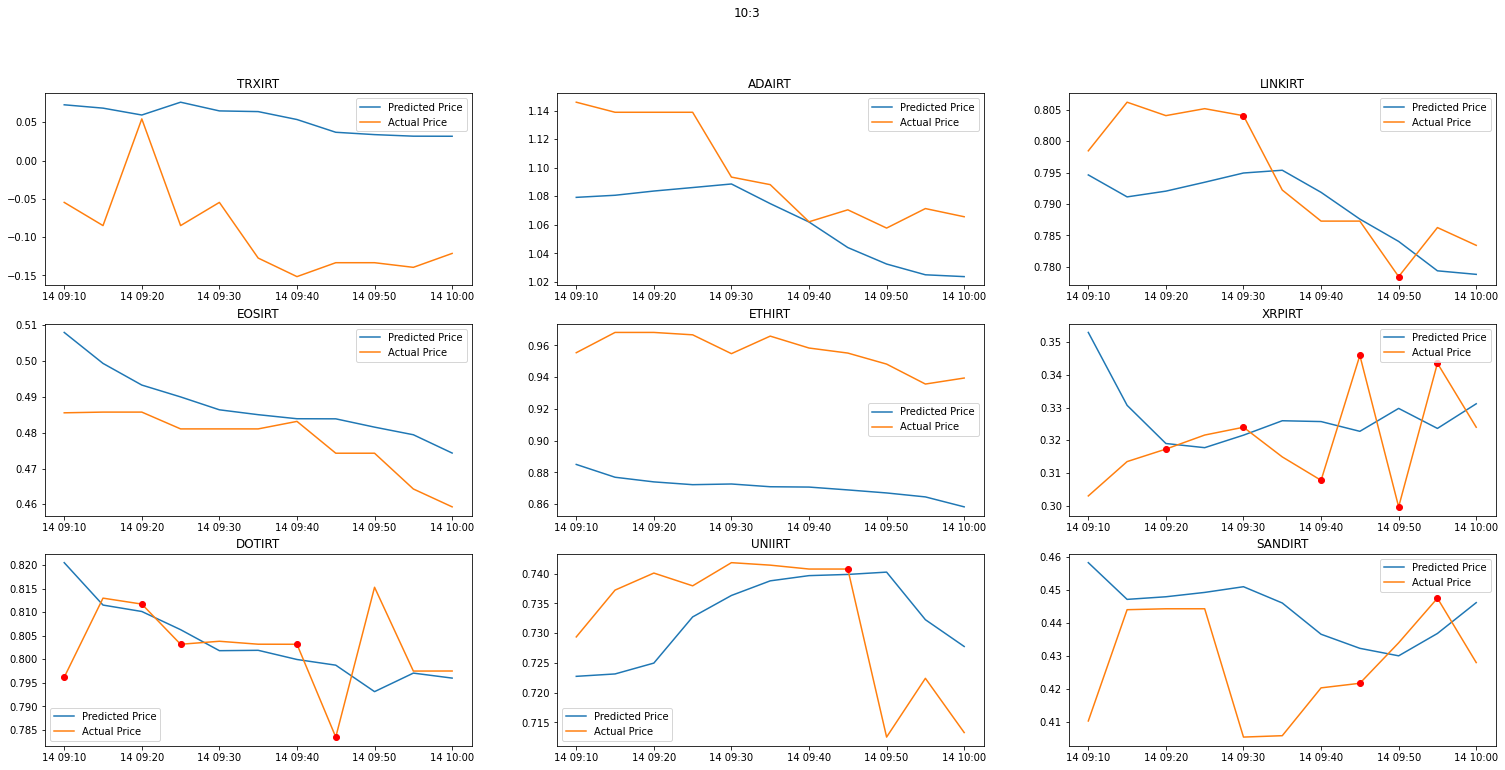

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: []
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '10:0', 'price': 11555.999989897013}]
signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.0010547638}, {'type': 'buy', 'time': '9:25', 'price': 281549.9980151653}, {'type': 'sel', 'time': '9:40', 'price': 281549.99801

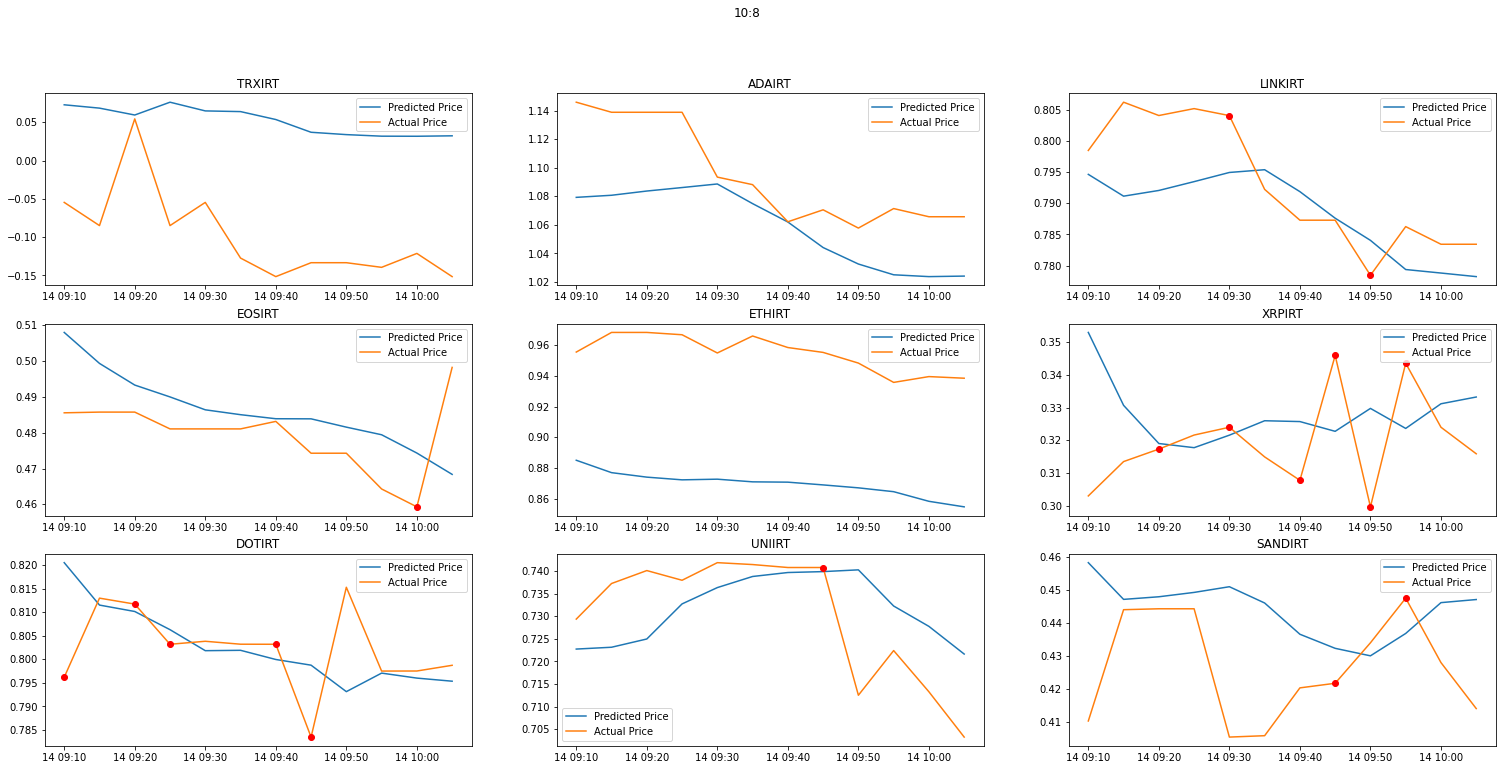

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:5', 'price': 40839.99992084503}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '9:55', 'price': 11596.999973744154}]
signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.0010547638}, {'type': 'buy', 'time': '9:25', 'price': 281549.9980151

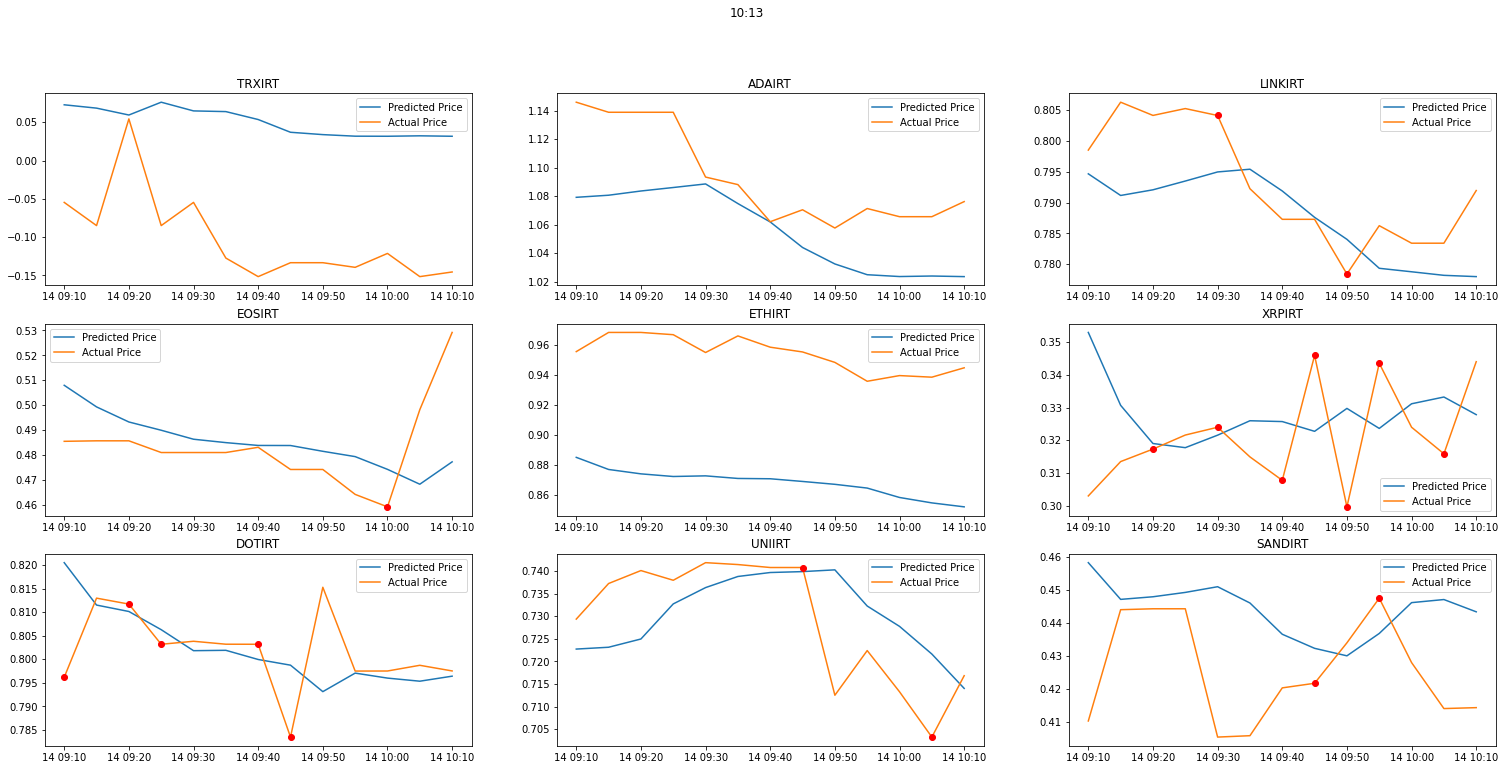

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '9:55', 'price': 11596.999973744154}, {'type': 'buy', 'time': '10:10', 'price': 11598.000014662743}]
signals DOTIRT: [{'type': 'buy', 'time': '9:10', 'price': 281001.001060009}, {'type': 'sel', 'time': '9:20', 'price': 282219.00105

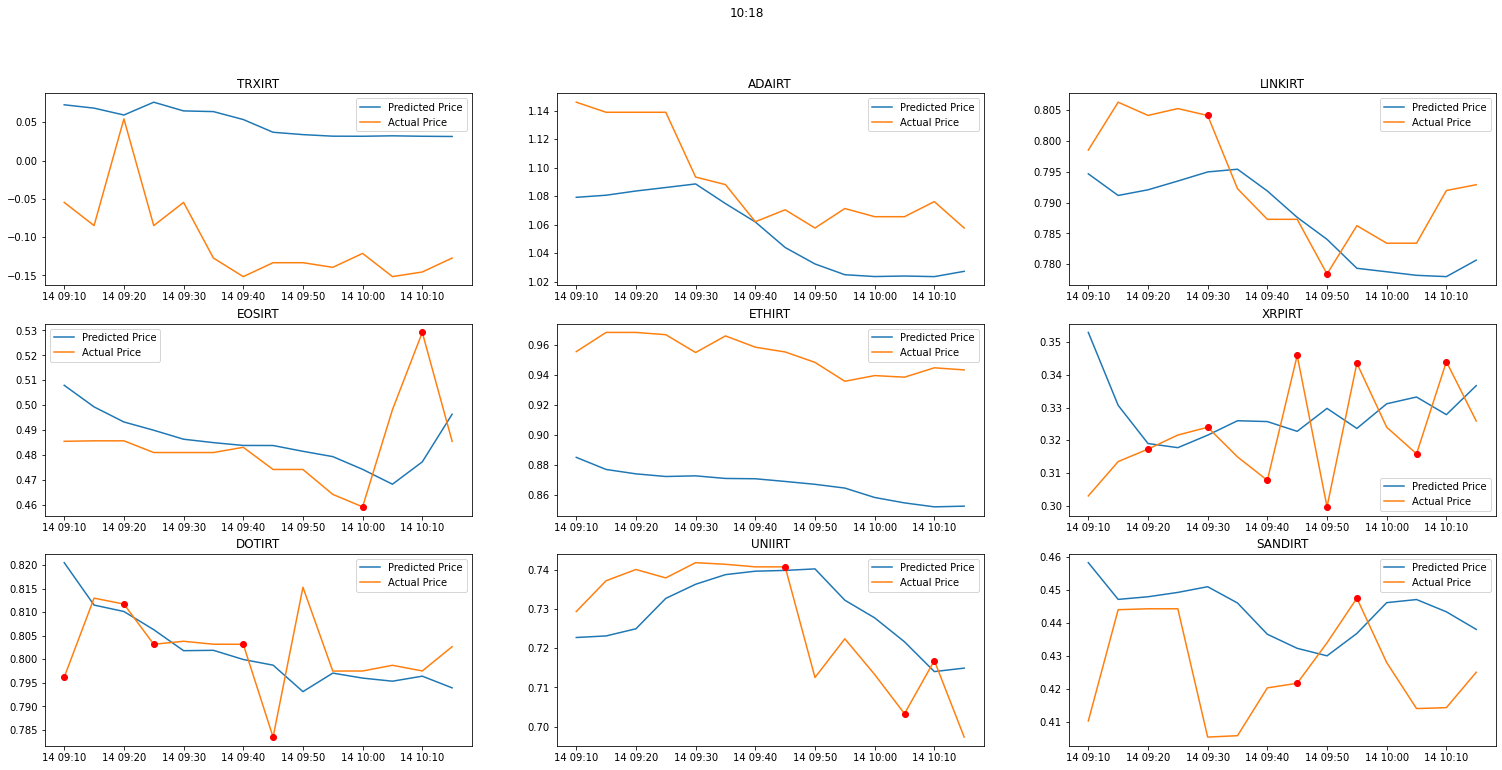

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:15', 'price': 40712.9999345839}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '9:55', 'price': 11596.999973744154}, {'type': 'buy', 'time': '10:5', 'price': 11538.99998435378}, {'type': 'sel', 'time': '10:15', 'price': 11560.00002810359}]
signals D

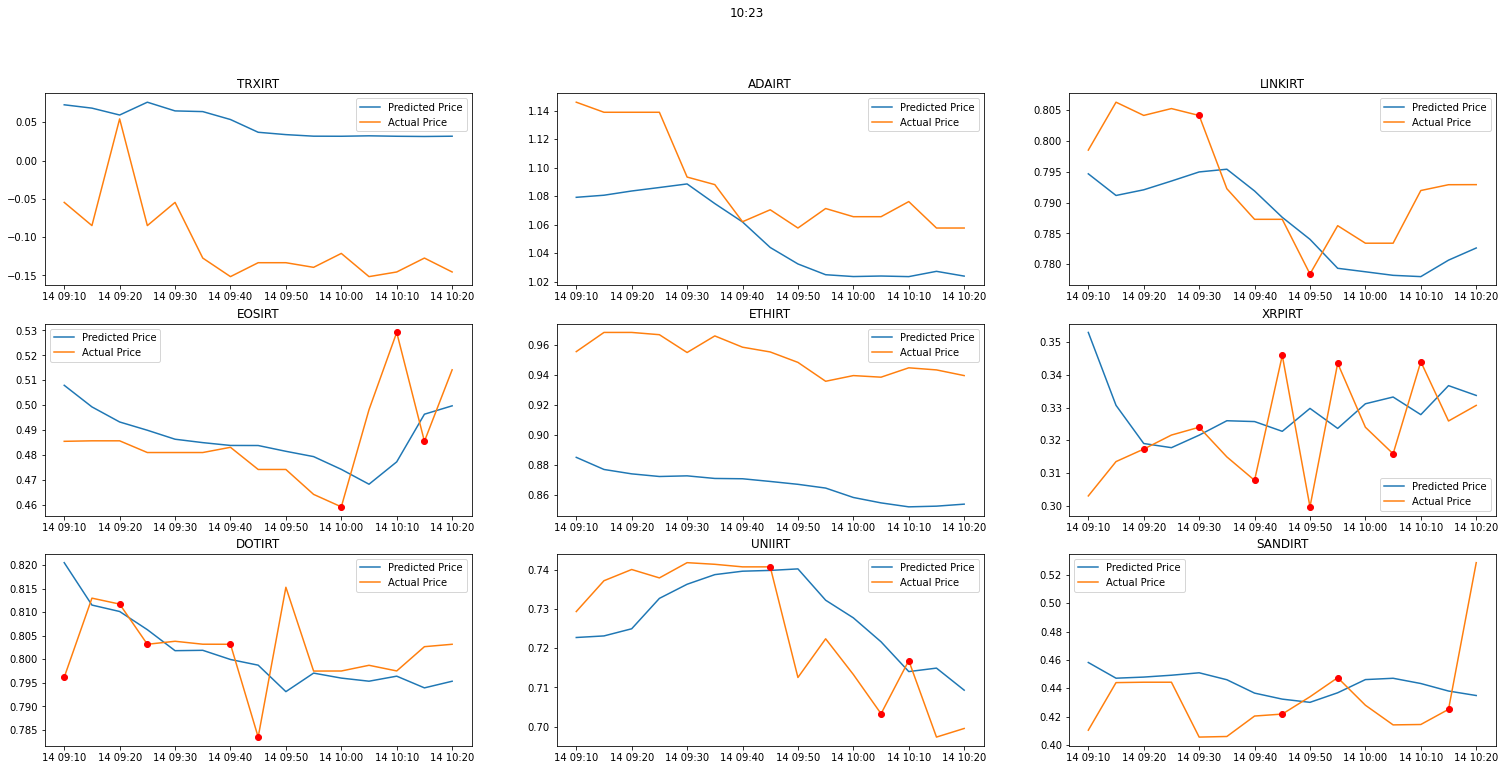

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:10', 'price': 41149.99978864193}, {'type': 'buy', 'time': '10:20', 'price': 41000.000218331814}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '9:55', 'price': 11596.999973744154}, {'type': 'buy', 'time': '10:5', 'price': 11538.99998435378}, {'type'

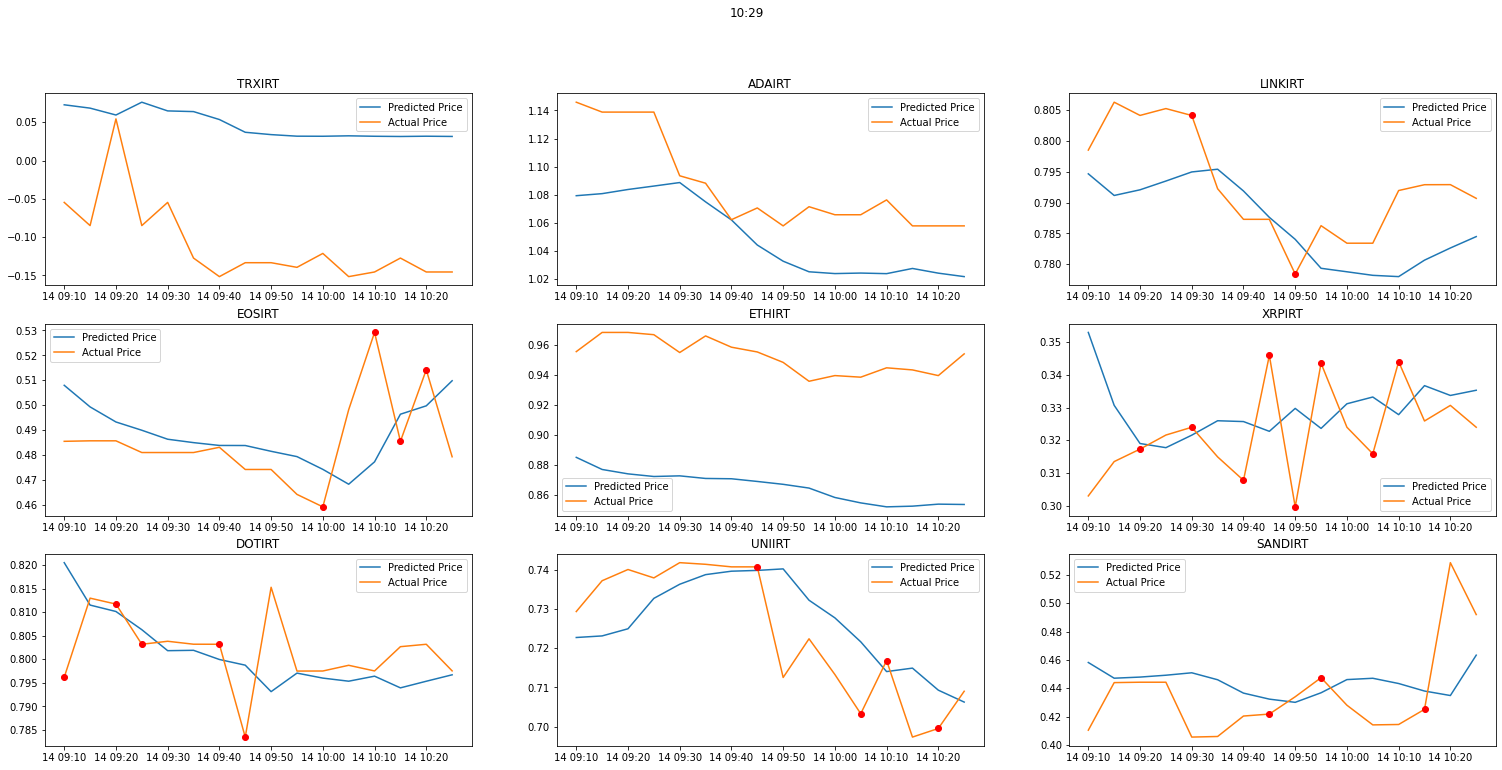

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:10', 'price': 41149.99978864193}, {'type': 'buy', 'time': '10:15', 'price': 40712.9999345839}, {'type': 'sel', 'time': '10:25', 'price': 40650.99990135431}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '9:55', 'price': 11596.999973744154}, {'type':

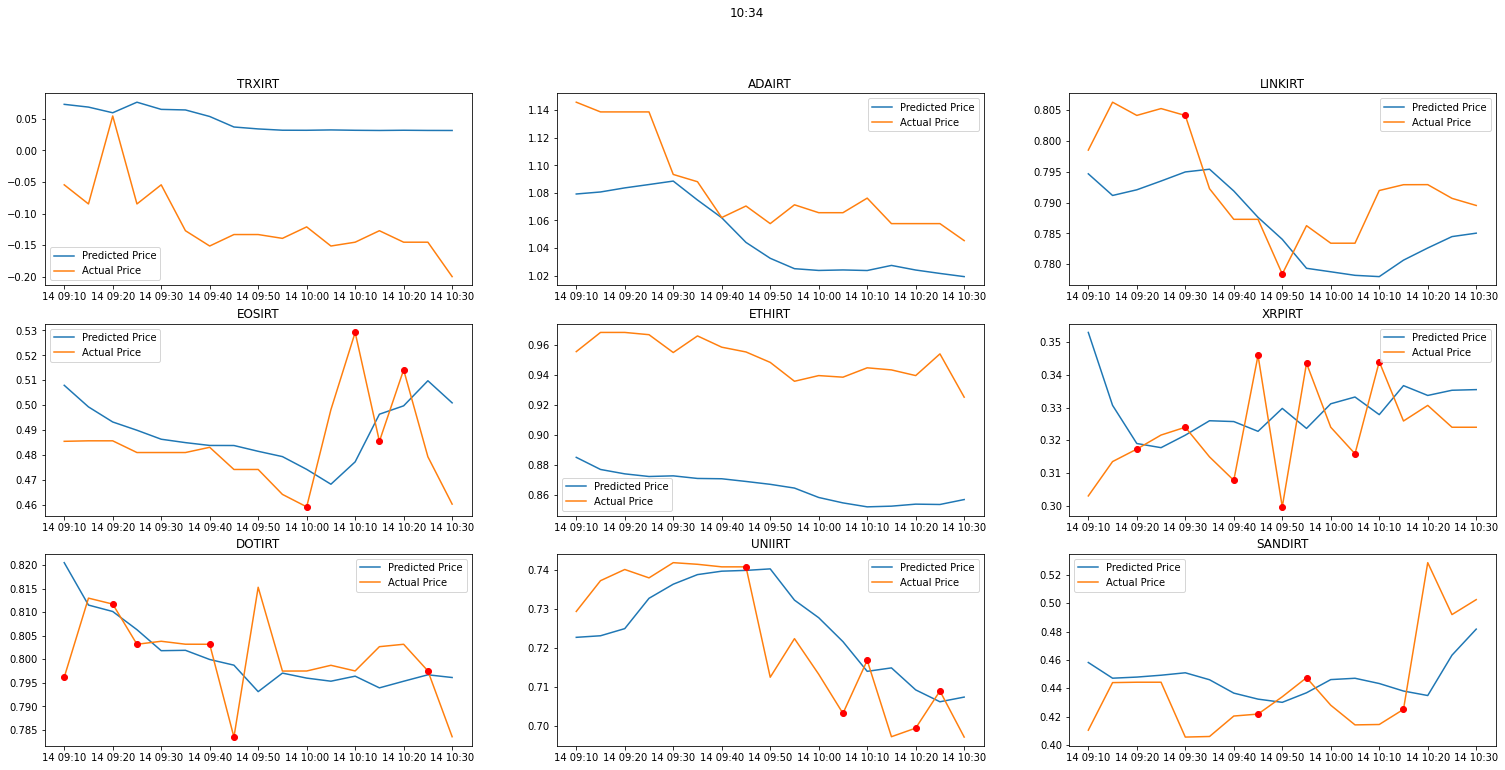

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: []
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:10', 'price': 41149.99978864193}, {'type': 'buy', 'time': '10:15', 'price': 40712.9999345839}, {'type': 'sel', 'time': '10:20', 'price': 41000.000218331814}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type': 'sel', 'time': '9:55', 'price': 11596.999973744154}, {'type'

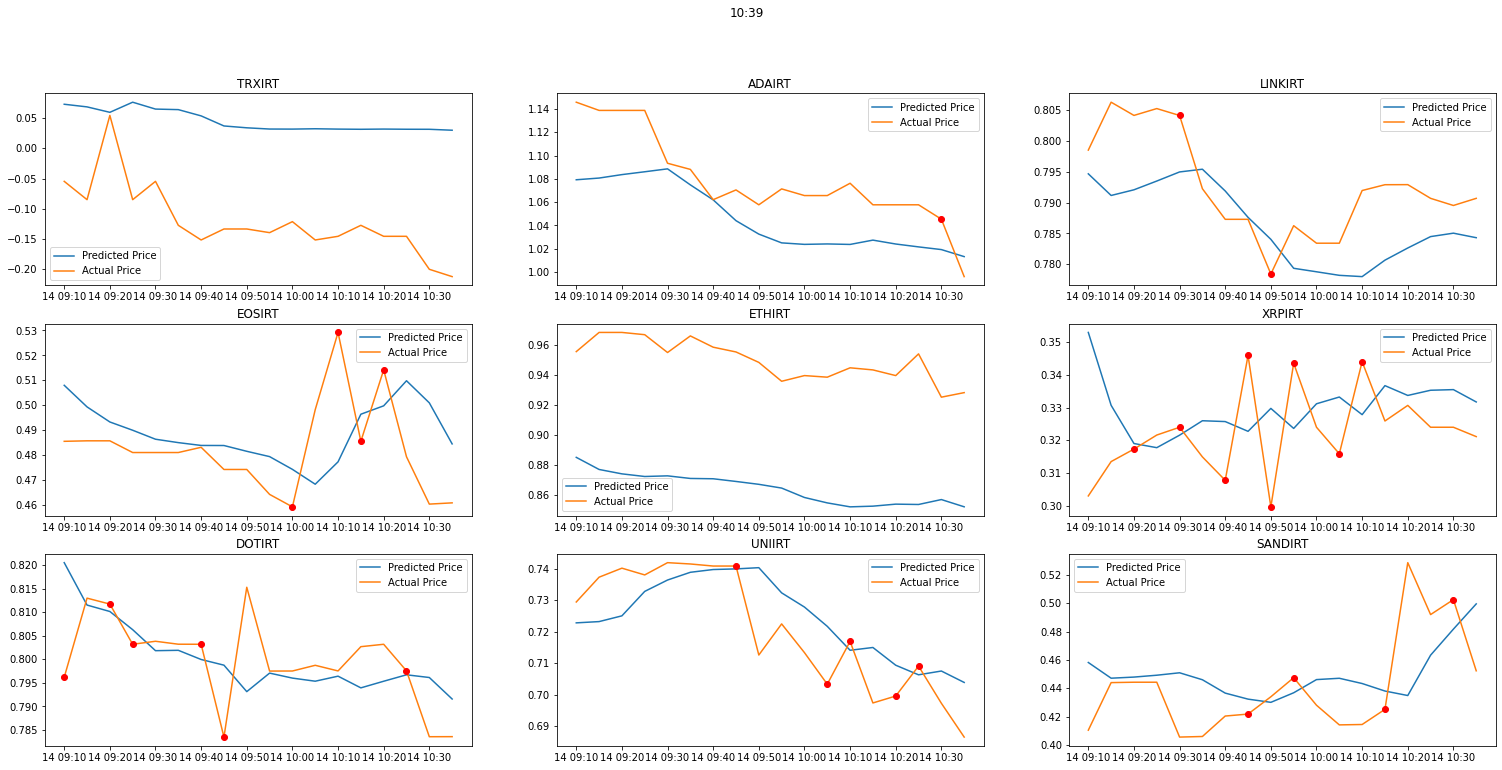

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: [{'type': 'sel', 'time': '10:35', 'price': 17359.999988138676}]
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:10', 'price': 41149.99978864193}, {'type': 'buy', 'time': '10:15', 'price': 40712.9999345839}, {'type': 'sel', 'time': '10:20', 'price': 41000.000218331814}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type':

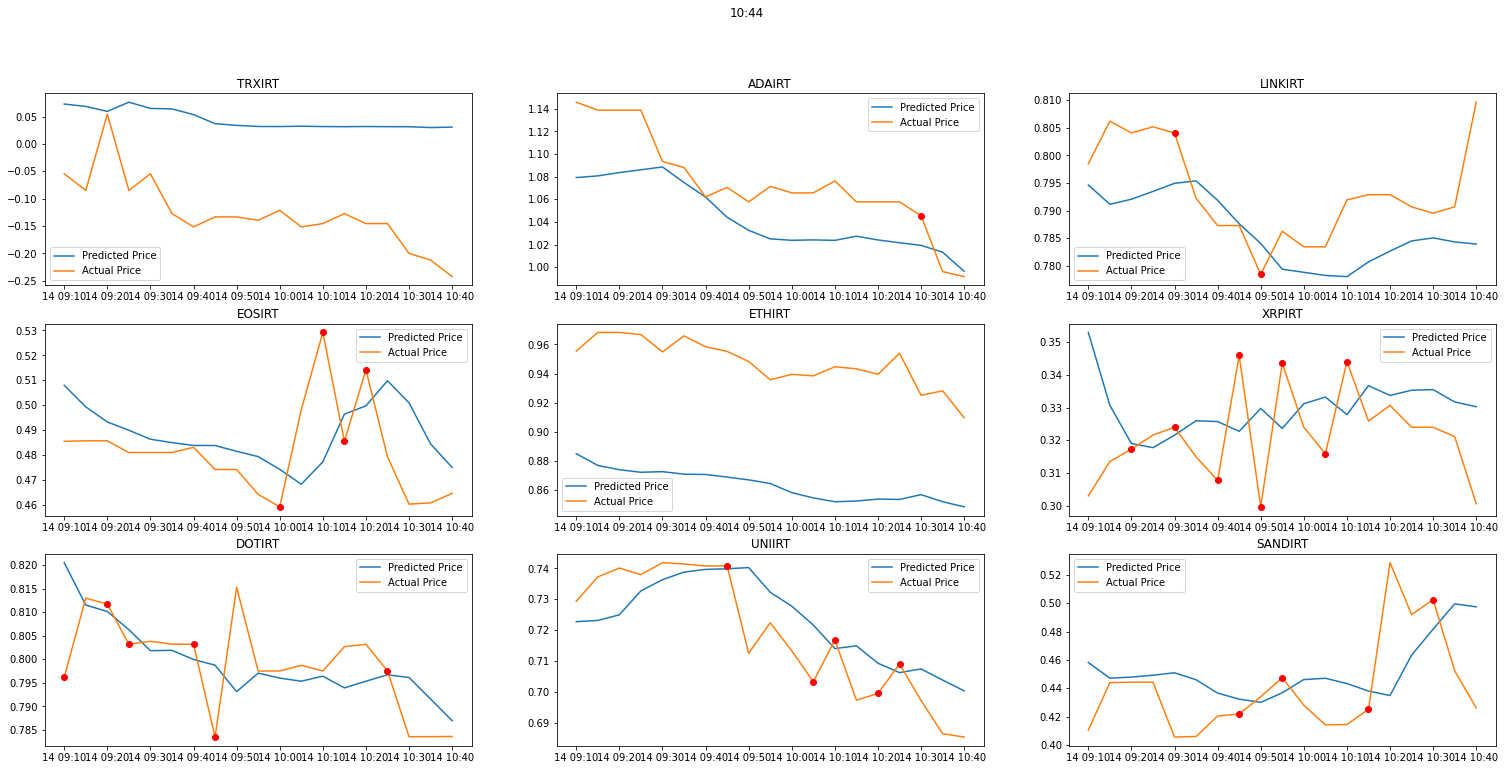

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: [{'type': 'sel', 'time': '10:30', 'price': 17471.999940395355}]
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:10', 'price': 41149.99978864193}, {'type': 'buy', 'time': '10:15', 'price': 40712.9999345839}, {'type': 'sel', 'time': '10:20', 'price': 41000.000218331814}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type':

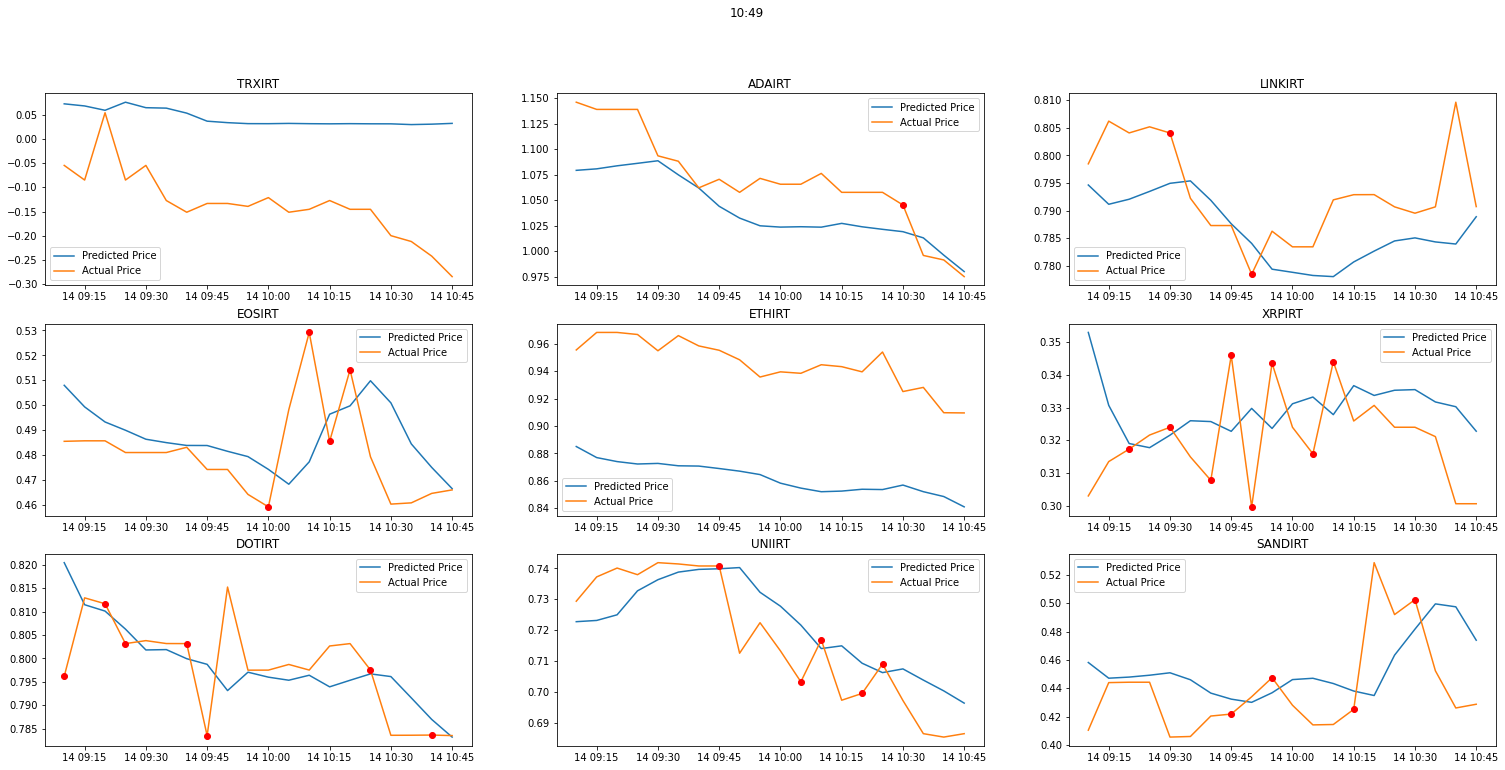

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: [{'type': 'sel', 'time': '10:30', 'price': 17471.999940395355}]
signals LINKIRT: [{'type': 'sel', 'time': '9:30', 'price': 275499.9992930889}, {'type': 'buy', 'time': '9:50', 'price': 273210.00192832947}]
signals EOSIRT: [{'type': 'buy', 'time': '10:0', 'price': 40449.99990430474}, {'type': 'sel', 'time': '10:10', 'price': 41149.99978864193}, {'type': 'buy', 'time': '10:15', 'price': 40712.9999345839}, {'type': 'sel', 'time': '10:20', 'price': 41000.000218331814}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '9:20', 'price': 11541.99998164177}, {'type': 'sel', 'time': '9:30', 'price': 11555.999989897013}, {'type': 'buy', 'time': '9:40', 'price': 11521.999978810549}, {'type': 'sel', 'time': '9:45', 'price': 11601.999990135431}, {'type': 'buy', 'time': '9:50', 'price': 11504.999973267317}, {'type':

KeyboardInterrupt: ignored

In [ ]:
import requests
import json
import datetime
import time
import telegram
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def get_csv(symbol, start_date,end_date, res):

  start_date_stamp  = int(time.mktime(datetime.datetime.strptime(start_date,'%Y-%m-%d').timetuple()))
  end_date_stamp  = int(time.mktime(datetime.datetime.strptime(f'{end_date} 23:59','%Y-%m-%d %H:%M').timetuple()))

  url = f"https://api.nobitex.ir/market/udf/history?symbol={symbol}&resolution={res}&from={start_date_stamp}&to={end_date_stamp}"

  payload={}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)

  res = response.text
  y = json.loads(res)
  df = pd.DataFrame({'Date':y['t'][::-1],'Close':y['c'][::-1], 'Open':y['o'], 'High':y['h'], 'Low':y['o']})
  df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Tehran')))
  return df

def get_csv_datetime(symbol, start_date,end_date, res):

  start_date_stamp  = int(datetime.datetime.timestamp(start_date) )
  end_date_stamp  = int(datetime.datetime.timestamp(end_date))

  url = f"https://api.nobitex.ir/market/udf/history?symbol={symbol}&resolution={res}&from={start_date_stamp}&to={end_date_stamp}"
  payload={}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)

  res = response.text
  y = json.loads(res)
  df = pd.DataFrame({'Date':y['t'][::-1],'Close':y['c'][::-1], 'Open':y['o'], 'High':y['h'], 'Low':y['o']})
  df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Tehran')))
  return df


def window_dataframe(df, start_date,end_date,num_of_features):
  
  #windowed_df = df[ (start_date <= df['Date']) & (df['Date'] <= end_date)]
  windowed_df = df[['Date','Close']]
  windowed_df = windowed_df.rename({'Close':'target'}, axis=1)

  for n in range(num_of_features):
    feature = []
    for index in range(len(windowed_df)):
      if index + num_of_features >= len(windowed_df):
        feature.append(0)
      else:
        feature.append(windowed_df.loc[index+n+1].target)
    windowed_df[f'target-{n+1}'] = feature

  windowed_df.drop(windowed_df.tail(num_of_features).index, inplace=True)
  return windowed_df

def windowed_df_to_date_X_y(windowed_df):
  
  windowed_df = windowed_df.sort_values(by='Date')

  df_as_np = windowed_df.to_numpy()

  dates = df_as_np[:,0]

  X = df_as_np[:,2:]

  X = X.reshape((len(dates), X.shape[1],1))

  Y = df_as_np[:,1]

  return dates, X.astype(np.float32), Y.astype(np.float32)




cryptoes = [
    {'symbol':'TRXIRT'},
    {'symbol':'ADAIRT'},
    {'symbol':'LINKIRT'},
    {'symbol':'EOSIRT'},
    {'symbol':'ETHIRT'},
    {'symbol':'XRPIRT'},
    {'symbol':'DOTIRT'},
    {'symbol':'UNIIRT'},
    {'symbol':'SANDIRT'}
]



TELEGRAM_BOT_TOKEN = '5474558689:AAEqdTKZdqLdw10P7BZhlo9lTN89AxJLQv4'
TELEGRAM_CHAT_ID = '-1001639881360'

bot = telegram.Bot(token=TELEGRAM_BOT_TOKEN)




for crypto in cryptoes:
  model = load_model(f'models/{crypto["symbol"]}.h5')
  crypto['model'] = model



# get the start time
start_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
start_time = start_time - datetime.timedelta(hours=1)

DAYS_TO_RUN = 1
## Consider that we are running this for a day.
end_time = start_time + datetime.timedelta(days = DAYS_TO_RUN+1)

times = 0



start_date = '2022-07-27'
end_date = '2022-08-12'
for index, crypto in enumerate(cryptoes):
  m_df = get_csv(crypto['symbol'], start_date, end_date,'60')
  crypto['min'] = m_df.Close.min()
  crypto['max'] = m_df.Close.max()
  print(f'{crypto["symbol"]} : {crypto["min"]} - {crypto["max"]}')

  


while(datetime.datetime.now(tz=pytz.timezone('Asia/Tehran')) < end_time):
  for index, crypto in enumerate(cryptoes):
    #for crypto in cryptoes:
    symbol = crypto['symbol']
    print(symbol)
    ## Getting the data
    now_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
    if times == 0:
      new_df = get_csv_datetime(symbol,start_time, now_time ,'5')
    else:
      new_df = get_csv_datetime(symbol,now_time - datetime.timedelta(minutes=11), now_time ,'5')
    # Normalizing the data
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    new_df['Close'] = new_df['Close'].apply(lambda x: str(x).replace(',',''))
    new_df['Close'] = pd.to_numeric(new_df['Close'],errors='coerce')
    min = crypto['min']
    max = crypto['max']
    new_df.Close = (new_df.Close - min) / (max - min)

    if len(new_df) < 4:

      crypto['df'].loc[-1] = new_df.loc[0]
      crypto['df'].index = crypto['df'].index + 1
      crypto['df'] = crypto['df'].sort_index()
    else:
      crypto['df'] = new_df
      print(new_df)
    ## Windowing the df
    windowed_df = window_dataframe(crypto['df'],'1999-1-1','2090-1-1',4)
    dates, X,y = windowed_df_to_date_X_y(windowed_df)
    crypto['dates'] = dates
    crypto['X'] = X
    crypto['y'] = y

  
  fig = plt.figure(figsize=(26,12))
  fig.suptitle(f'{now_time.hour}:{now_time.minute}')
  axes = fig.subplots(nrows=3,ncols=3)
  for index, crypto in enumerate(cryptoes):
      ax = axes[int(index/3)][index%3]
      y_preds = crypto['model'].predict(crypto['X']).flatten()
      idx = np.argwhere(np.diff(np.sign(crypto['y'] - y_preds))).flatten()

      ax.set_title(crypto['symbol'])

      min = crypto['min']
      max = crypto['max']
      
      signals = []
      for id in idx:
        price = crypto['y'][id] * (max-min) + min
        time_str = f'{crypto["dates"][id].hour}:{crypto["dates"][id].minute}' 
        if id+1 < len(crypto['y']):
          if crypto['y'][id] < y_preds[id]:
            signals.append({'type':'buy','time':time_str, 'price':price})
          elif crypto['y'][id] > y_preds[id]:
            signals.append({'type':'sel','time':time_str, 'price':price})
          else:
            if crypto['y'][id] < crypto['y'][id+1]:
              signals.append({'type':'buy','time':time_str, 'price':price})
            elif crypto['y'][id] > crypto['y'][id+1]:
              signals.append({'type':'sel','time':time_str, 'price':price})
      

      
      if times == 0:
        crypto['signals'] = signals
        message = f'lost signals {crypto["symbol"]}: {signals}'  
        print(message)
        bot.send_message(chat_id=TELEGRAM_CHAT_ID, text=message)
      else:
        len_new =  len(signals) - len(crypto['signals'])
        if len_new > 0:
          new_signals = signals[(-1) * len_new:]
          for signal in new_signals:
            signal['time'] = f'{crypto["dates"][-1].hour}:{crypto["dates"][-1].minute}' 
            signal['price'] = crypto['y'][-1] * (max-min) + min
          message = f'new signals {crypto["symbol"]}: {new_signals}'
          print(message)
          ##TODO:: send message telegram
          bot.send_message(chat_id=TELEGRAM_CHAT_ID, text=message)
        crypto['signals'] = signals
      

      ax.plot(crypto['dates'], y_preds)

      ax.plot(crypto['dates'],crypto['y'])
      ax.plot(dates[idx], crypto['y'][idx], 'ro' )
      ax.legend(['Predicted Price','Actual Price'])
  
  fig.savefig('chart-5.jpg')
  bot.send_photo(chat_id=TELEGRAM_CHAT_ID, photo=open('chart-5.jpg', 'rb'))

  times+=1
  plt.show()
  print('----------------------------------------------------------------------------------------------------------------------------------------------')
  for crypto in cryptoes:
    print(f'signals {crypto["symbol"]}: {crypto["signals"]}')
  time.sleep(300)





In [ ]:
import requests
import json
import datetime
import time
import telegram
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def get_csv(symbol, start_date,end_date, res):

  start_date_stamp  = int(time.mktime(datetime.datetime.strptime(start_date,'%Y-%m-%d').timetuple()))
  end_date_stamp  = int(time.mktime(datetime.datetime.strptime(f'{end_date} 23:59','%Y-%m-%d %H:%M').timetuple()))

  url = f"https://api.nobitex.ir/market/udf/history?symbol={symbol}&resolution={res}&from={start_date_stamp}&to={end_date_stamp}"

  payload={}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)

  res = response.text
  y = json.loads(res)
  df = pd.DataFrame({'Date':y['t'][::-1],'Close':y['c'][::-1], 'Open':y['o'], 'High':y['h'], 'Low':y['o']})
  df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Tehran')))
  return df

def get_csv_datetime(symbol, start_date,end_date, res):

  start_date_stamp  = int(datetime.datetime.timestamp(start_date) )
  end_date_stamp  = int(datetime.datetime.timestamp(end_date))

  url = f"https://api.nobitex.ir/market/udf/history?symbol={symbol}&resolution={res}&from={start_date_stamp}&to={end_date_stamp}"
  payload={}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)

  res = response.text
  y = json.loads(res)
  df = pd.DataFrame({'Date':y['t'][::-1],'Close':y['c'][::-1], 'Open':y['o'], 'High':y['h'], 'Low':y['o']})
  df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Tehran')))
  return df


def window_dataframe(df, start_date,end_date,num_of_features):
  
  #windowed_df = df[ (start_date <= df['Date']) & (df['Date'] <= end_date)]
  windowed_df = df[['Date','Close']]
  windowed_df = windowed_df.rename({'Close':'target'}, axis=1)

  for n in range(num_of_features):
    feature = []
    for index in range(len(windowed_df)):
      if index + num_of_features >= len(windowed_df):
        feature.append(0)
      else:
        feature.append(windowed_df.loc[index+n+1].target)
    windowed_df[f'target-{n+1}'] = feature

  windowed_df.drop(windowed_df.tail(num_of_features).index, inplace=True)
  return windowed_df

def windowed_df_to_date_X_y(windowed_df):
  
  windowed_df = windowed_df.sort_values(by='Date')

  df_as_np = windowed_df.to_numpy()

  dates = df_as_np[:,0]

  X = df_as_np[:,2:]

  X = X.reshape((len(dates), X.shape[1],1))

  Y = df_as_np[:,1]

  return dates, X.astype(np.float32), Y.astype(np.float32)




cryptoes = [
    {'symbol':'TRXIRT'},
    {'symbol':'ADAIRT'},
    {'symbol':'LINKIRT'},
    {'symbol':'EOSIRT'},
    {'symbol':'ETHIRT'},
    {'symbol':'XRPIRT'},
    {'symbol':'DOTIRT'},
    {'symbol':'UNIIRT'},
    {'symbol':'SANDIRT'}
]



TELEGRAM_BOT_TOKEN = '5474558689:AAEqdTKZdqLdw10P7BZhlo9lTN89AxJLQv4'
TELEGRAM_CHAT_ID = '-1001639881360'

bot = telegram.Bot(token=TELEGRAM_BOT_TOKEN)




for crypto in cryptoes:
  model = load_model(f'models/{crypto["symbol"]}.h5')
  crypto['model'] = model



# get the start time
start_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
start_time = start_time - datetime.timedelta(hours=1,minutes=30)

DAYS_TO_RUN = 1
## Consider that we are running this for a day.
end_time = start_time + datetime.timedelta(days = DAYS_TO_RUN+1)

times = 0



start_date = '2022-07-27'
end_date = '2022-08-12'
for index, crypto in enumerate(cryptoes):
  m_df = get_csv(crypto['symbol'], start_date, end_date,'60')
  crypto['min'] = m_df.Close.min()
  crypto['max'] = m_df.Close.max()
  print(f'{crypto["symbol"]} : {crypto["min"]} - {crypto["max"]}')

  


while(datetime.datetime.now(tz=pytz.timezone('Asia/Tehran')) < end_time):
  for index, crypto in enumerate(cryptoes):
    #for crypto in cryptoes:
    symbol = crypto['symbol']
    print(symbol)
    ## Getting the data
    now_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
    if times == 0:
      new_df = get_csv_datetime(symbol,start_time, now_time ,'5')
    else:
      new_df = get_csv_datetime(symbol,now_time - datetime.timedelta(minutes=11), now_time ,'5')
    # Normalizing the data
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    new_df['Close'] = new_df['Close'].apply(lambda x: str(x).replace(',',''))
    new_df['Close'] = pd.to_numeric(new_df['Close'],errors='coerce')
    min = crypto['min']
    max = crypto['max']
    new_df.Close = (new_df.Close - min) / (max - min)

    if len(new_df) < 4:

      crypto['df'].loc[-1] = new_df.loc[0]
      crypto['df'].index = crypto['df'].index + 1
      crypto['df'] = crypto['df'].sort_index()
    else:
      crypto['df'] = new_df
      print(new_df)
    ## Windowing the df
    windowed_df = window_dataframe(crypto['df'],'1999-1-1','2090-1-1',4)
    dates, X,y = windowed_df_to_date_X_y(windowed_df)
    crypto['dates'] = dates
    crypto['X'] = X
    crypto['y'] = y

  
  fig = plt.figure(figsize=(26,12))
  fig.suptitle(f'{now_time.hour}:{now_time.minute}')
  axes = fig.subplots(nrows=3,ncols=3)
  for index, crypto in enumerate(cryptoes):
      ax = axes[int(index/3)][index%3]
      y_preds = crypto['model'].predict(crypto['X']).flatten()
      idx = np.argwhere(np.diff(np.sign(crypto['y'] - y_preds))).flatten()
      #idx = list(map(lambda x:x+1, idx))
      ax.set_title(crypto['symbol'])

      min = crypto['min']
      max = crypto['max']
      
      signals = []
      for id in idx:
        price = crypto['y'][id] * (max-min) + min
        time_str = f'{crypto["dates"][id].hour}:{crypto["dates"][id].minute}' 
        if id+1 < len(crypto['y']):
          if crypto['y'][id] < y_preds[id]:
            signals.append({'type':'sell','time':time_str, 'price':price,'idx':id})
          elif crypto['y'][id] > y_preds[id]:
            signals.append({'type':'buy','time':time_str, 'price':price,'idx':id})
          else:
            if crypto['y'][id] < crypto['y'][id+1]:
              signals.append({'type':'sell','time':time_str, 'price':price,'idx':id})
            elif crypto['y'][id] > crypto['y'][id+1]:
              signals.append({'type':'buy','time':time_str, 'price':price, 'idx':id})
      
      if times == 0:
        crypto['signals'] = signals
        message = f'lost signals {crypto["symbol"]}: {signals}'  
        print(message)
        bot.send_message(chat_id=TELEGRAM_CHAT_ID, text=message)
      else:
        len_new =  len(signals) - len(crypto['signals'])
        if len_new > 0:
          new_signals = signals[(-1) * len_new:]
          for signal in new_signals:
            signal['time'] = f'{crypto["dates"][-1].hour}:{crypto["dates"][-1].minute}' 
            signal['price'] = crypto['y'][-1] * (max-min) + min
          message = f'new signals {crypto["symbol"]}: {new_signals}'
          print(message)
          ##TODO:: send message telegram
          bot.send_message(chat_id=TELEGRAM_CHAT_ID, text=message)
        crypto['signals'] = signals
      

      ax.plot(crypto['dates'], y_preds)

      ax.plot(crypto['dates'],crypto['y'])
      sells = [signal['idx']+1 for signal in list(filter(lambda x:x['type'] == 'sell', signals))]
      buys = [signal['idx']+1 for signal in list(filter(lambda x:x['type'] == 'buy', signals))]

      ax.plot(dates[sells], crypto['y'][sells], 'ro' )
      ax.plot(dates[buys], crypto['y'][buys], 'go' )
      ax.legend(['Predicted Price','Actual Price','Sell Points','Buy Points'])
  
  fig.savefig('chart-5.jpg')
  bot.send_photo(chat_id=TELEGRAM_CHAT_ID, photo=open('chart-5.jpg', 'rb'))

  times+=1
  plt.show()
  print('----------------------------------------------------------------------------------------------------------------------------------------------')
  for crypto in cryptoes:
    print(f'signals {crypto["symbol"]}: {crypto["signals"]}')
  time.sleep(300)





ModuleNotFoundError: ignored

In [ ]:
list(filter(lambda x:x['type'] == 'buy',cryptoes[0]['signals']))

[{'idx': 10, 'price': 2172.00000038743, 'time': '2:0', 'type': 'buy'},
 {'idx': 12, 'price': 2177.000000536442, 'time': '4:0', 'type': 'buy'},
 {'idx': 16, 'price': 2179.999997675419, 'time': '8:0', 'type': 'buy'}]

# Final Code .py for 15 minute time frame

TRXIRT : 2126.0 - 2291.0
ADAIRT : 15100.0 - 17369.0
LINKIRT : 203681.0 - 292999.0
EOSIRT : 35852.0 - 45863.0
ETHIRT : 46980000.0 - 60200000.0
XRPIRT : 10874.0 - 12979.0
DOTIRT : 218500.0 - 297000.0
UNIIRT : 213000.0 - 306229.0
SANDIRT : 37796.0 - 44990.0
TRXIRT
ADAIRT
LINKIRT
EOSIRT
ETHIRT
XRPIRT
DOTIRT
UNIIRT
SANDIRT
lost signals TRXIRT: []
lost signals ADAIRT: [{'type': 'sel', 'time': '2:30', 'price': 17133.999975800514}, {'type': 'buy', 'time': '3:0', 'price': 17044.99997872114}]
lost signals LINKIRT: []
lost signals EOSIRT: [{'type': 'buy', 'time': '1:45', 'price': 40927.99975627661}]
lost signals ETHIRT: []
lost signals XRPIRT: [{'type': 'buy', 'time': '2:0', 'price': 11524.999976098537}, {'type': 'sel', 'time': '2:30', 'price': 11580.00003093481}]
lost signals DOTIRT: []
lost signals UNIIRT: []
lost signals SANDIRT: []


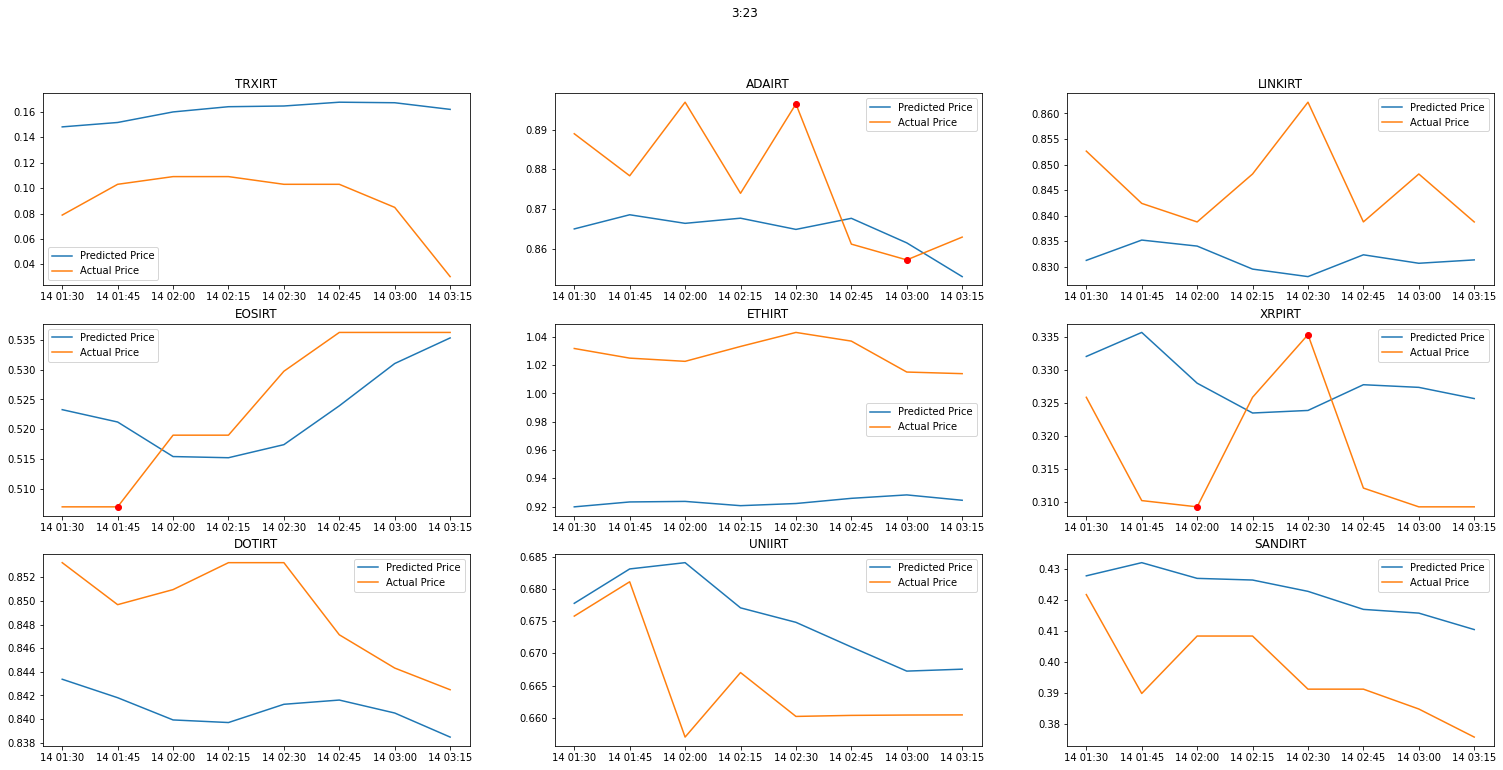

----------------------------------------------------------------------------------------------------------------------------------------------
signals TRXIRT: []
signals ADAIRT: [{'type': 'sel', 'time': '2:30', 'price': 17133.999975800514}, {'type': 'buy', 'time': '3:0', 'price': 17044.99997872114}]
signals LINKIRT: []
signals EOSIRT: [{'type': 'buy', 'time': '1:45', 'price': 40927.99975627661}]
signals ETHIRT: []
signals XRPIRT: [{'type': 'buy', 'time': '2:0', 'price': 11524.999976098537}, {'type': 'sel', 'time': '2:30', 'price': 11580.00003093481}]
signals DOTIRT: []
signals UNIIRT: []
signals SANDIRT: []


KeyboardInterrupt: ignored

In [ ]:
import requests
import json
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import telegram
import pytz
from tensorflow.keras.models import load_model

def get_csv(symbol, start_date,end_date, res):

  start_date_stamp  = int(time.mktime(datetime.datetime.strptime(start_date,'%Y-%m-%d').timetuple()))
  end_date_stamp  = int(time.mktime(datetime.datetime.strptime(f'{end_date} 23:59','%Y-%m-%d %H:%M').timetuple()))

  url = f"https://api.nobitex.ir/market/udf/history?symbol={symbol}&resolution={res}&from={start_date_stamp}&to={end_date_stamp}"

  payload={}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)

  res = response.text
  y = json.loads(res)
  df = pd.DataFrame({'Date':y['t'][::-1],'Close':y['c'][::-1], 'Open':y['o'], 'High':y['h'], 'Low':y['o']})
  df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Tehran')))
  return df

def get_csv_datetime(symbol, start_date,end_date, res):

  start_date_stamp  = int(datetime.datetime.timestamp(start_date) )
  end_date_stamp  = int(datetime.datetime.timestamp(end_date))

  url = f"https://api.nobitex.ir/market/udf/history?symbol={symbol}&resolution={res}&from={start_date_stamp}&to={end_date_stamp}"
  payload={}
  headers = {}

  response = requests.request("GET", url, headers=headers, data=payload)

  res = response.text
  y = json.loads(res)
  df = pd.DataFrame({'Date':y['t'][::-1],'Close':y['c'][::-1], 'Open':y['o'], 'High':y['h'], 'Low':y['o']})
  df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=pytz.timezone('Asia/Tehran')))
  return df


def window_dataframe(df, start_date,end_date,num_of_features):
  
  #windowed_df = df[ (start_date <= df['Date']) & (df['Date'] <= end_date)]
  windowed_df = df[['Date','Close']]
  windowed_df = windowed_df.rename({'Close':'target'}, axis=1)

  for n in range(num_of_features):
    feature = []
    for index in range(len(windowed_df)):
      if index + num_of_features >= len(windowed_df):
        feature.append(0)
      else:
        feature.append(windowed_df.loc[index+n+1].target)
    windowed_df[f'target-{n+1}'] = feature

  windowed_df.drop(windowed_df.tail(num_of_features).index, inplace=True)
  return windowed_df

def windowed_df_to_date_X_y(windowed_df):
  
  windowed_df = windowed_df.sort_values(by='Date')

  df_as_np = windowed_df.to_numpy()

  dates = df_as_np[:,0]

  X = df_as_np[:,2:]

  X = X.reshape((len(dates), X.shape[1],1))

  Y = df_as_np[:,1]

  return dates, X.astype(np.float32), Y.astype(np.float32)




cryptoes = [
    {'symbol':'TRXIRT'},
    {'symbol':'ADAIRT'},
    {'symbol':'LINKIRT'},
    {'symbol':'EOSIRT'},
    {'symbol':'ETHIRT'},
    {'symbol':'XRPIRT'},
    {'symbol':'DOTIRT'},
    {'symbol':'UNIIRT'},
    {'symbol':'SANDIRT'}
]



TELEGRAM_BOT_TOKEN = '5474558689:AAEqdTKZdqLdw10P7BZhlo9lTN89AxJLQv4'
TELEGRAM_CHAT_ID = '-1001452031899'

bot = telegram.Bot(token=TELEGRAM_BOT_TOKEN)




for crypto in cryptoes:
  model = load_model(f'models/{crypto["symbol"]}.h5')
  crypto['model'] = model



# get the start time
start_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
start_time = start_time - datetime.timedelta(hours=3)

DAYS_TO_RUN = 1
## Consider that we are running this for a day.
end_time = start_time + datetime.timedelta(days = DAYS_TO_RUN+1)

times = 0



start_date = '2022-07-27'
end_date = '2022-08-12'
for index, crypto in enumerate(cryptoes):
  m_df = get_csv(crypto['symbol'], start_date, end_date,'60')
  crypto['min'] = m_df.Close.min()
  crypto['max'] = m_df.Close.max()
  print(f'{crypto["symbol"]} : {crypto["min"]} - {crypto["max"]}')

  


while(datetime.datetime.now(tz=pytz.timezone('Asia/Tehran')) < end_time):
  for index, crypto in enumerate(cryptoes):
    #for crypto in cryptoes:
    symbol = crypto['symbol']
    print(symbol)
    ## Getting the data
    now_time = datetime.datetime.now(tz=pytz.timezone('Asia/Tehran'))
    if times == 0:
      new_df = get_csv_datetime(symbol,start_time, now_time ,'15')
    else:
      new_df = get_csv_datetime(symbol,now_time - datetime.timedelta(minutes=32), now_time ,'15')
    # Normalizing the data
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    new_df['Close'] = new_df['Close'].apply(lambda x: str(x).replace(',',''))
    new_df['Close'] = pd.to_numeric(new_df['Close'],errors='coerce')
    min = crypto['min']
    max = crypto['max']
    new_df.Close = (new_df.Close - min) / (max - min)

    if len(new_df) < 4:

      crypto['df'].loc[-1] = new_df.loc[0]
      crypto['df'].index = crypto['df'].index + 1
      crypto['df'] = crypto['df'].sort_index()
    else:
      crypto['df'] = new_df
    ## Windowing the df
    windowed_df = window_dataframe(crypto['df'],'1999-1-1','2090-1-1',4)
    dates, X,y = windowed_df_to_date_X_y(windowed_df)
    crypto['dates'] = dates
    crypto['X'] = X
    crypto['y'] = y

  
  fig = plt.figure(figsize=(26,12))
  fig.suptitle(f'{now_time.hour}:{now_time.minute}')
  axes = fig.subplots(nrows=3,ncols=3)
  for index, crypto in enumerate(cryptoes):
      ax = axes[int(index/3)][index%3]
      y_preds = crypto['model'].predict(crypto['X']).flatten()
      idx = np.argwhere(np.diff(np.sign(crypto['y'] - y_preds))).flatten()

      ax.set_title(crypto['symbol'])

      min = crypto['min']
      max = crypto['max']
      
      signals = []
      for id in idx:
        price = crypto['y'][id] * (max-min) + min
        time_str = f'{crypto["dates"][id].hour}:{crypto["dates"][id].minute}' 
        if id+1 < len(crypto['y']):
          if crypto['y'][id] < y_preds[id]:
            signals.append({'type':'buy','time':time_str, 'price':price})
          elif crypto['y'][id] > y_preds[id]:
            signals.append({'type':'sel','time':time_str, 'price':price})
          else:
            if crypto['y'][id] < crypto['y'][id+1]:
              signals.append({'type':'buy','time':time_str, 'price':price})
            elif crypto['y'][id] > crypto['y'][id+1]:
              signals.append({'type':'sel','time':time_str, 'price':price})
      

      
      if times == 0:
        crypto['signals'] = signals
        message = f'lost signals {crypto["symbol"]}: {signals}'  
        print(message)
        bot.send_message(chat_id=TELEGRAM_CHAT_ID, text=message)
      else:
        len_new =  len(signals) - len(crypto['signals'])
        if len_new > 0:
          new_signals = signals[(-1) * len_new:]
          for signal in new_signals:
            signal['time'] = f'{crypto["dates"][-1].hour}:{crypto["dates"][-1].minute}' 
            signal['price'] = crypto['y'][-1] * (max-min) + min
          message = f'new signals {crypto["symbol"]}: {new_signals}'
          print(message)
          ##TODO:: send message telegram
          bot.send_message(chat_id=TELEGRAM_CHAT_ID, text=message)
        crypto['signals'] = signals
      

      ax.plot(crypto['dates'], y_preds)

      ax.plot(crypto['dates'],crypto['y'])
      ax.plot(dates[idx], crypto['y'][idx], 'ro' )
      ax.legend(['Predicted Price','Actual Price'])
  
  fig.savefig('chart-15.jpg')
  bot.send_photo(chat_id=TELEGRAM_CHAT_ID, photo=open('chart-15.jpg', 'rb'))

  times+=1
  plt.show()
  print('----------------------------------------------------------------------------------------------------------------------------------------------')
  for crypto in cryptoes:
    print(f'signals {crypto["symbol"]}: {crypto["signals"]}')
  time.sleep(900)





# Crypto currencies list to review
- TRX
- CARDANO
- CHAINLINK
- EOS
- ETH


In [ ]:
start_date = '2022-08-11'
end_date = '2022-08-12'
resolution = '15'

cryptoes = [
    {'symbol':'TRXIRT'},
    {'symbol':'ADAIRT'},
    {'symbol':'LINKIRT'},
    {'symbol':'EOSIRT'},
    {'symbol':'ETHIRT'},
    {'symbol':'XRPIRT'},
    {'symbol':'DOTIRT'},
    {'symbol':'UNIIRT'},
    {'symbol':'SANDIRT'}
]


dataframes = []
for crypto in cryptoes:
  dataframes.append(get_csv(crypto['symbol'], start_date, end_date,resolution))

In [ ]:
dataframes[0]

Date   Close    Open    High     Low
0   2022-08-13 04:28:00+04:30  2175.0  2173.0  2177.0  2173.0
1   2022-08-13 04:27:00+04:30  2175.0  2174.0  2174.0  2174.0
2   2022-08-13 04:26:00+04:30  2175.0  2177.0  2177.0  2177.0
3   2022-08-13 04:25:00+04:30  2177.0  2174.0  2174.0  2174.0
4   2022-08-13 04:24:00+04:30  2177.0  2177.0  2177.0  2177.0
..                        ...     ...     ...     ...     ...
495 2022-08-12 20:13:00+04:30  2177.0  2177.0  2177.0  2177.0
496 2022-08-12 20:12:00+04:30  2174.0  2177.0  2177.0  2177.0
497 2022-08-12 20:11:00+04:30  2174.0  2175.0  2175.0  2175.0
498 2022-08-12 20:10:00+04:30  2174.0  2175.0  2175.0  2175.0
499 2022-08-12 20:09:00+04:30  2177.0  2175.0  2175.0  2175.0

[500 rows x 5 columns]

In [ ]:
min_max_dfs = []

for df in dataframes:
  df['Date'] = pd.to_datetime(df['Date'])
  df['Close'] = df['Close'].apply(lambda x: str(x).replace(',',''))
  df['Close'] = pd.to_numeric(df['Close'],errors='coerce')
  min = df.Close.min()
  max = df.Close.max()
  df.Close.max()
  df.Close = (df.Close - min) / (max - min)
  

In [ ]:
f'ADA:{len(dataframes[1])}, {len(dataframes[0])}, {len(dataframes[2])} '

'ADA:422, 422, 422 '

In [ ]:
dataframes[0]

Date     Close    Open    High     Low
0   2022-08-13 04:28:00+04:30  0.588235  2173.0  2177.0  2173.0
1   2022-08-13 04:27:00+04:30  0.588235  2174.0  2174.0  2174.0
2   2022-08-13 04:26:00+04:30  0.588235  2177.0  2177.0  2177.0
3   2022-08-13 04:25:00+04:30  0.705882  2174.0  2174.0  2174.0
4   2022-08-13 04:24:00+04:30  0.705882  2177.0  2177.0  2177.0
..                        ...       ...     ...     ...     ...
495 2022-08-12 20:13:00+04:30  0.705882  2177.0  2177.0  2177.0
496 2022-08-12 20:12:00+04:30  0.529412  2177.0  2177.0  2177.0
497 2022-08-12 20:11:00+04:30  0.529412  2175.0  2175.0  2175.0
498 2022-08-12 20:10:00+04:30  0.529412  2175.0  2175.0  2175.0
499 2022-08-12 20:09:00+04:30  0.705882  2175.0  2175.0  2175.0

[500 rows x 5 columns]

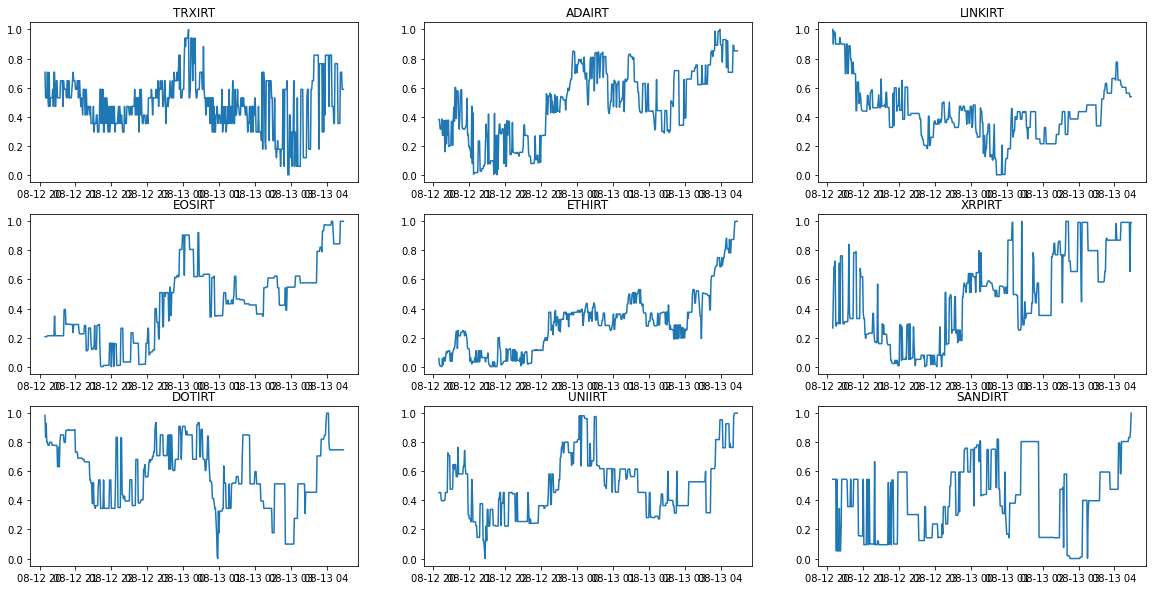

In [ ]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3,ncols=3)

for index, df in enumerate(dataframes):
  ax = axes[int(index/3)][index%3]
  ax.set_title(cryptoes[index]['symbol'])
  ax.plot(df.Date, df.Close)
plt.show()


In [ ]:
def window_dataframe(df, start_date,end_date,num_of_features):
  
  #windowed_df = df[ (start_date <= df['Date']) & (df['Date'] <= end_date)]
  windowed_df = df[['Date','Close']]
  windowed_df = windowed_df.rename({'Close':'target'}, axis=1)

  for n in range(num_of_features):
    feature = []
    for index in range(len(windowed_df)):
      if index + num_of_features >= len(windowed_df):
        feature.append(0)
      else:
        feature.append(windowed_df.loc[index+n+1].target)
    windowed_df[f'target-{n+1}'] = feature

  windowed_df.drop(windowed_df.tail(num_of_features).index, inplace=True)
  return windowed_df




In [ ]:
windowed_dfs = list(map(lambda x: window_dataframe(x,start_date,end_date,4), dataframes))

windowed_dfs[1]

Date    target  target-1  target-2  target-3  \
0   2022-08-13 11:00:00+04:30  0.925518  0.879683  0.687528  0.701190   
1   2022-08-13 10:00:00+04:30  0.879683  0.687528  0.701190  0.704275   
2   2022-08-13 09:00:00+04:30  0.687528  0.701190  0.704275  0.682680   
3   2022-08-13 08:00:00+04:30  0.701190  0.704275  0.682680  0.689731   
4   2022-08-13 07:00:00+04:30  0.704275  0.682680  0.689731  0.652270   
..                        ...       ...       ...       ...       ...   
406 2022-07-27 13:00:00+04:30  0.080652  0.155134  0.179374  0.111944   
407 2022-07-27 12:00:00+04:30  0.155134  0.179374  0.111944  0.101366   
408 2022-07-27 11:00:00+04:30  0.179374  0.111944  0.101366  0.013222   
409 2022-07-27 10:00:00+04:30  0.111944  0.101366  0.013222  0.000000   
410 2022-07-27 09:00:00+04:30  0.101366  0.013222  0.000000  0.048480   

     target-4  
0    0.704275  
1    0.682680  
2    0.689731  
3    0.652270  
4    0.699868  
..        ...  
406  0.101366  
407  0.013222  
408  0.000000  
409  0.048480  
410  0.052887  

[411 rows x 6 columns]

In [ ]:
def windowed_df_to_date_X_y(windowed_df):
  
  windowed_df = windowed_df.sort_values(by='Date')

  df_as_np = windowed_df.to_numpy()

  dates = df_as_np[:,0]

  X = df_as_np[:,2:]

  X = X.reshape((len(dates), X.shape[1],1))

  Y = df_as_np[:,1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


In [ ]:
Dates_Xs_ys = []
for windowed_df in windowed_dfs:
  dates, X, y = windowed_df_to_date_X_y(windowed_df)
  Dates_Xs_ys.append({
      'dates':dates,
      'X':X,
      'y':y
  })

In [ ]:
Dates_Xs_ys[0]['dates']

array([Timestamp('2022-07-27 09:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 10:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 11:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 12:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 13:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 14:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 15:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 16:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 17:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 18:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 19:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 20:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 21:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 22:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-27 23:00:00+0430', tz='Asia/Tehran'),
       Timestamp('2022-07-28 00:00:00+04

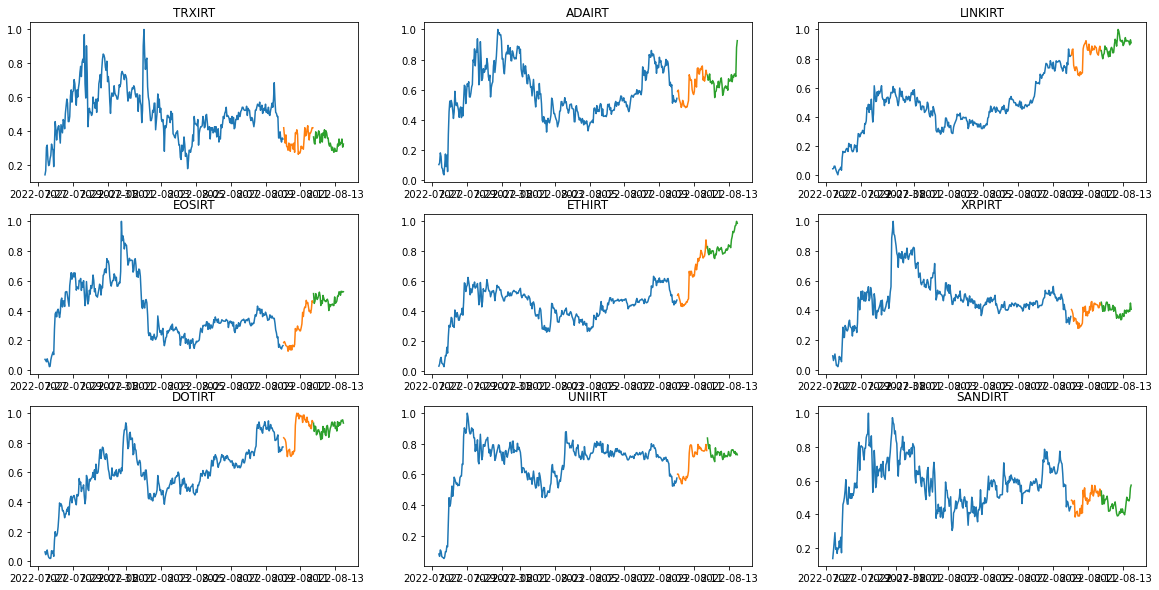

In [ ]:
datasets_splited = []

for dates_X_y in Dates_Xs_ys:
  q_80 = int(len(dates_X_y['dates'])*0.8)
  q_90 = int(len(dates_X_y['dates'])*0.9)

  dates_train, X_train, y_train = dates_X_y['dates'][:q_80], dates_X_y['X'][:q_80], dates_X_y['y'][:q_80]
  dates_val, X_val, y_val = dates_X_y['dates'][q_80:q_90], dates_X_y['X'][q_80:q_90], dates_X_y['y'][q_80:q_90]
  dates_test, X_test, y_test = dates_X_y['dates'][q_90:], dates_X_y['X'][q_90:], dates_X_y['y'][q_90:]

  datasets_splited.append(
      {
        'train': {'dates':dates_train, 'X':X_train, 'y':y_train},
        'val': {'dates':dates_val, 'X':X_val, 'y':y_val},
        'test': {'dates':dates_test, 'X':X_test, 'y':y_test},
      }
  )
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3,ncols=3)

for index, ds in enumerate(datasets_splited):
  ax = axes[int(index/3)][index%3]
  ax.plot(ds['train']['dates'], ds['train']['y'])
  ax.plot(ds['val']['dates'], ds['val']['y'])
  ax.plot(ds['test']['dates'], ds['test']['y'])
  ax.set_title(cryptoes[index]['symbol'])


plt.show()


# Train the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
models = []

for dataset in datasets_splited:
  model = Sequential([layers.Input((X.shape[1],1)),
                      layers.LSTM(64),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(1) ])
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001),
                metrics=['mean_absolute_error'])

  model.fit(dataset['train']['X'], dataset['train']['y'], validation_data=(dataset['val']['X'],dataset['val']['y']), epochs=200)

  models.append(model)


Epoch 1/200
11/11 [==============================] - 3s 69ms/step - loss: 0.3276 - mean_absolute_error: 0.5500 - val_loss: 0.1303 - val_mean_absolute_error: 0.3573
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.2990 - mean_absolute_error: 0.5248 - val_loss: 0.1181 - val_mean_absolute_error: 0.3398
Epoch 3/200
11/11 [==============================] - 0s 7ms/step - loss: 0.2766 - mean_absolute_error: 0.5039 - val_loss: 0.1076 - val_mean_absolute_error: 0.3241
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.2567 - mean_absolute_error: 0.4848 - val_loss: 0.0994 - val_mean_absolute_error: 0.3112
Epoch 5/200
11/11 [==============================] - 0s 9ms/step - loss: 0.2406 - mean_absolute_error: 0.4689 - val_loss: 0.0927 - val_mean_absolute_error: 0.3003
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 0.2272 - mean_absolute_error: 0.4550 - val_loss: 0.0864 - val_mean_absolute_error: 0.2897
Epoch 7/200
11/11 [==

In [ ]:
# save our models
from tensorflow.keras.models import load_model
import os
def save_models():
  os.makedirs('models',exist_ok=True)
  for index, model in enumerate(models):
    model.save(f'models/{cryptoes[index]["symbol"]}.h5')

save_models()


## Results for 1-year window

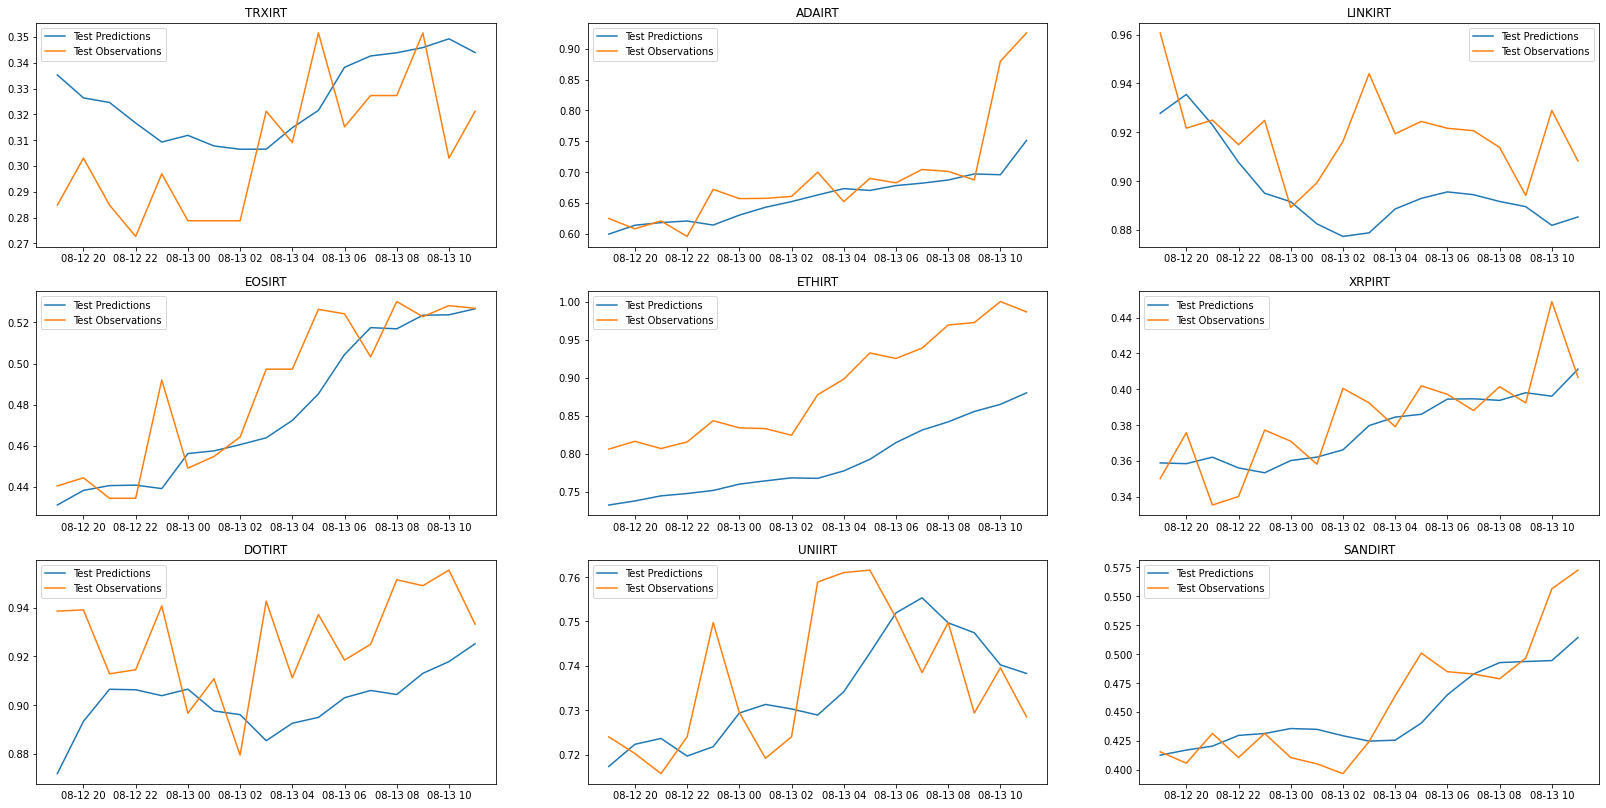

In [ ]:
a = -17
b = 100


fig = plt.figure(figsize=(28,14))
axes = fig.subplots(nrows=3,ncols=3)
for index, dataset in enumerate(datasets_splited):
  ax = axes[int(index/3)][index%3]
  dates = dataset['test']['dates'][a:b]
  y = dataset['test']['y'][a:b]
  X = dataset['test']['X'][a:b]
  test_predictions = models[index].predict(X).flatten()
  #test_predictions += 0.0095
  ax.plot(dates, test_predictions)
  ax.plot(dates, y)
  ax.legend(['Test Predictions','Test Observations'])
  ax.set_title(cryptoes[index]['symbol'])

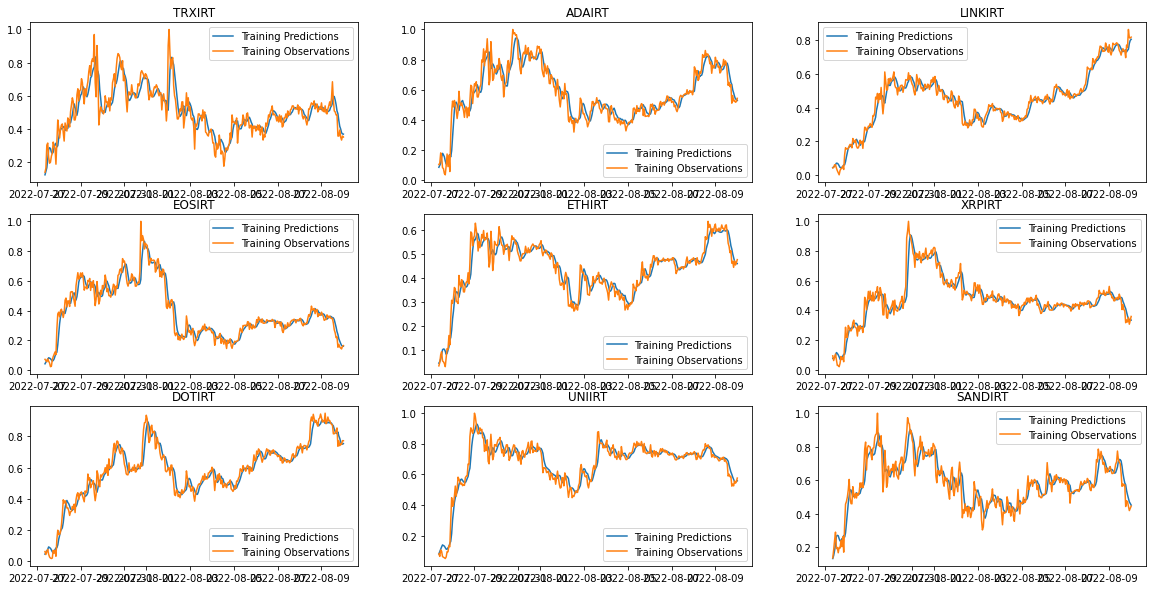

In [ ]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3,ncols=3)
for index, dataset in enumerate(datasets_splited):
  ax = axes[int(index/3)][index%3]
  train_predictions = models[index].predict(dataset['train']['X']).flatten()
  ax.plot(dataset['train']['dates'], train_predictions)
  ax.plot(dataset['train']['dates'], dataset['train']['y'])
  ax.legend(['Training Predictions','Training Observations'])
  ax.set_title(cryptoes[index]['symbol'])

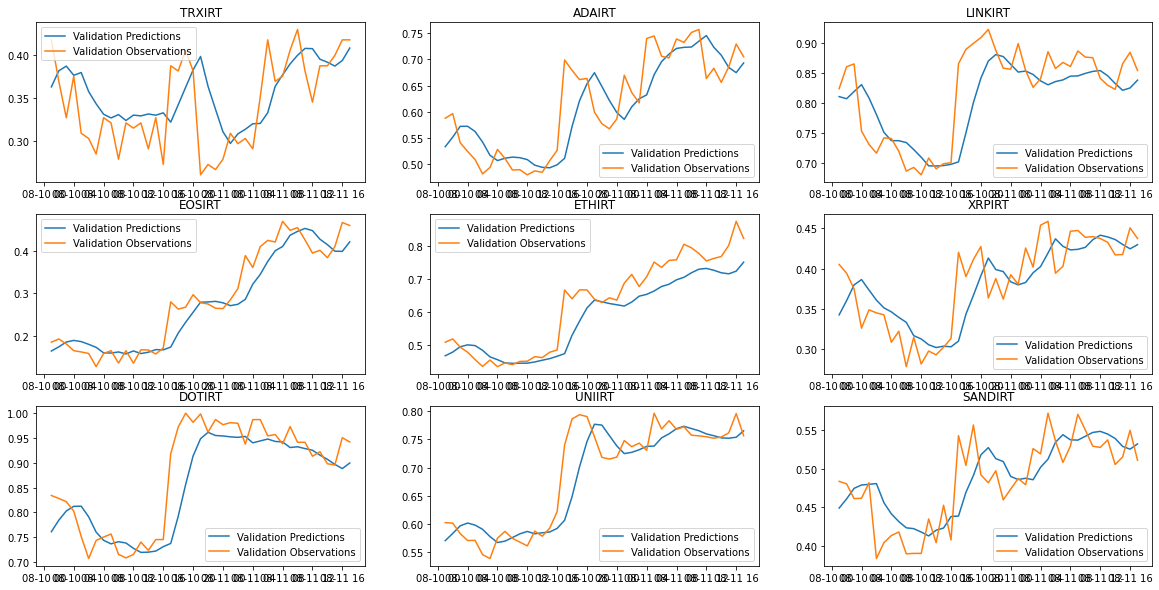

In [ ]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3,ncols=3)
for index, dataset in enumerate(datasets_splited):
  ax = axes[int(index/3)][index%3]
  train_predictions = models[index].predict(dataset['val']['X']).flatten()
  ax.plot(dataset['val']['dates'], train_predictions)
  ax.plot(dataset['val']['dates'], dataset['val']['y'])
  ax.legend(['Validation Predictions','Validation Observations'])
  ax.set_title(cryptoes[index]['symbol'])

# Daily trading plots

In [ ]:
datasets_splited[0]['test']['dates'][-19]

Timestamp('2022-08-12 00:00:00+0430', tz='Asia/Tehran')

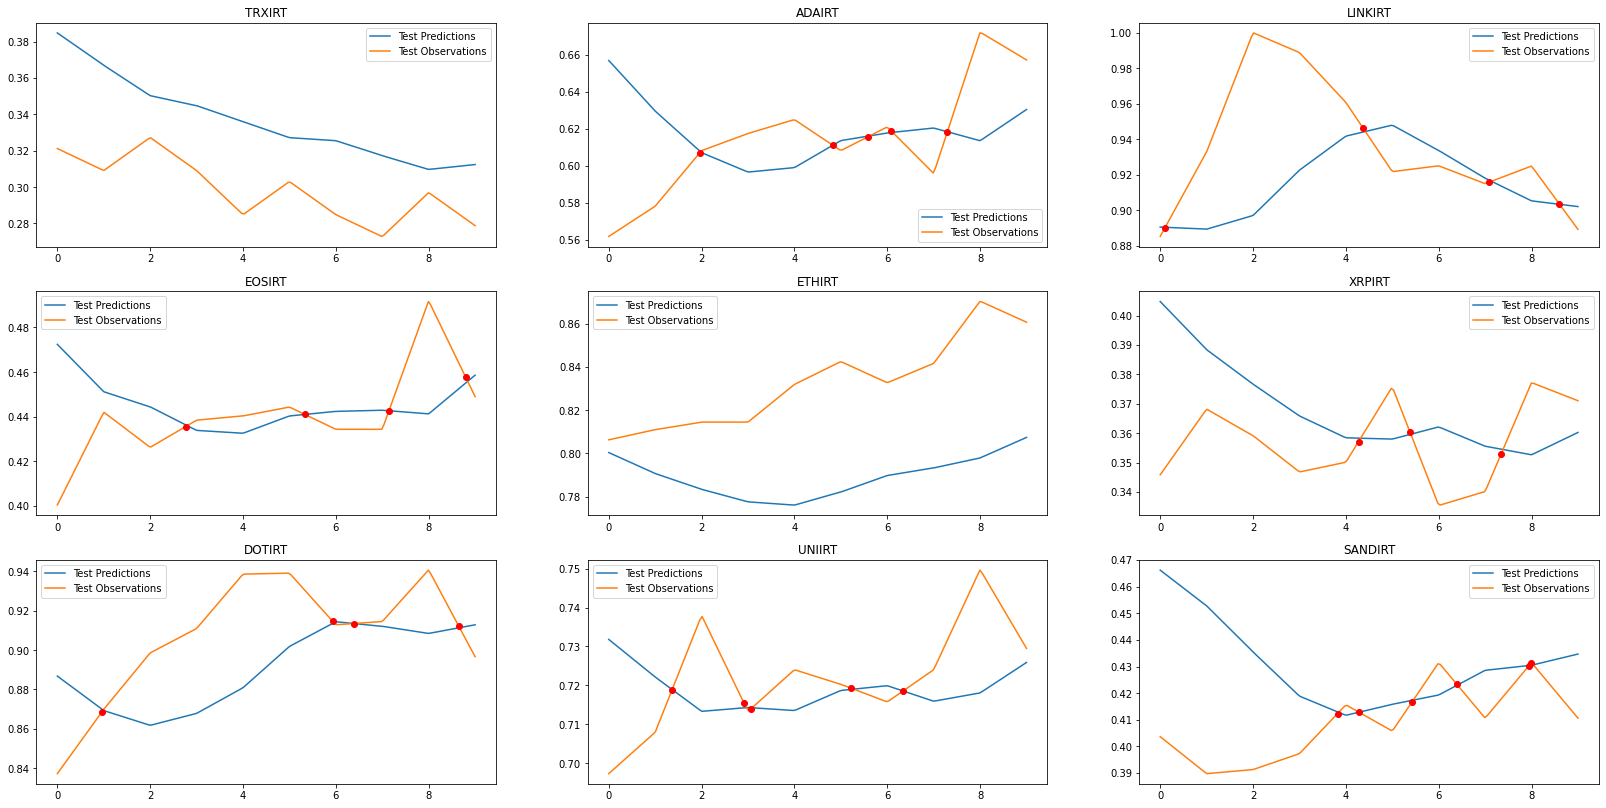

In [ ]:



a = -19
b = 100

signals_list = {}

fig = plt.figure(figsize=(28,14))
axes = fig.subplots(nrows=3,ncols=3)
for index, dataset in enumerate(datasets_splited):
  ax = axes[int(index/3)][index%3]
  dates = dataset['test']['dates'][a:b]
  y = dataset['test']['y'][a:b]
  X = dataset['test']['X'][a:b]
  last_hour = dates[-1].time().hour
  test_predictions = models[index].predict(X).flatten()
  #test_predictions += 0.0095

  x_vals = np.linspace(0, last_hour, 20 * last_hour)
  y_preds_interp = np.interp(x_vals, range(len(dates)), test_predictions)
  y_actual_interp = np.interp(x_vals, range(len(dates)), y)  

  ax.plot(x_vals, y_preds_interp)
  ax.plot(x_vals, y_actual_interp)
  ax.legend(['Test Predictions','Test Observations'])
  
  idx = np.argwhere(np.diff(np.sign(y_actual_interp - y_preds_interp))).flatten()
  ax.plot(x_vals[idx], y_actual_interp[idx], 'ro')
  ax.set_title(cryptoes[index]['symbol'])

  signals = []
  for id in idx:
    hour = int(x_vals[id])
    minutes  = int(float((x_vals[id] - int(x_vals[id])) * 60 ))
    time = f'{hour}:{minutes}'
    if id+1 < len(y_actual_interp):
      if y_actual_interp[id] < y_actual_interp[id+1]:
        signals.append({'type':'buy','time':time,'idx':id, 'price':y_actual_interp[id]})
      elif y_actual_interp[id] > y_actual_interp[id+1]:
        signals.append({'type':'sell','time':time,'idx':id, 'price':y_actual_interp[id]})
  
  signals_list[cryptoes[index]['symbol']] = signals


In [ ]:
def calculate_profit(signals_list):
  profits_list = {}
  total=0
  for crypto in cryptoes:
    crypto = crypto['symbol']
    signals = signals_list[crypto]
    profits = []
    total_per_crypto = 0
    for index in range(len(signals)):
      profit=0
      if index > 0:
        if signals[index]['type'] == 'sell' and signals[index-1]['type'] == 'buy':
          profit = (signals[index]['price'] - signals[index-1]['price']) / (signals[index-1]['price']) * 100
      
        total_per_crypto += profit
        profits.append(profit)
    total += total_per_crypto
    profits_list[crypto] = {'profits':profits, 'total-profit':total_per_crypto}
  profits_list['total'] = total
  return profits_list

In [ ]:
signals_list

{'ADAIRT': [{'idx': 39,
   'price': 0.6070254724784936,
   'time': '1:57',
   'type': 'buy'},
  {'idx': 96, 'price': 0.6110978512790616, 'time': '4:49', 'type': 'sell'},
  {'idx': 111, 'price': 0.615623262341462, 'time': '5:34', 'type': 'buy'},
  {'idx': 121, 'price': 0.6188732855146823, 'time': '6:5', 'type': 'sell'},
  {'idx': 145, 'price': 0.6180066086726482, 'time': '7:17', 'type': 'buy'}],
 'DOTIRT': [{'idx': 19,
   'price': 0.8684765157086889,
   'time': '0:57',
   'type': 'buy'},
  {'idx': 118, 'price': 0.9146246250781267, 'time': '5:55', 'type': 'sell'},
  {'idx': 127, 'price': 0.9135046025228234, 'time': '6:23', 'type': 'buy'},
  {'idx': 172, 'price': 0.9121843096930221, 'time': '8:38', 'type': 'sell'}],
 'EOSIRT': [{'idx': 55,
   'price': 0.43555831010115215,
   'time': '2:45',
   'type': 'buy'},
  {'idx': 106, 'price': 0.44101878984014414, 'time': '5:19', 'type': 'sell'},
  {'idx': 142, 'price': 0.44237204503746674, 'time': '7:8', 'type': 'buy'},
  {'idx': 175, 'price': 0.45

In [ ]:
profits_list = calculate_profit(signals_list)

In [ ]:
profits_list

{'ADAIRT': {'profits': [0.6708744501182805, 0, 0.5279240360182584, 0],
  'total-profit': 1.198798486136539},
 'DOTIRT': {'profits': [5.313685348391984, 0, -0.14453050659570127],
  'total-profit': 5.169154841796283},
 'EOSIRT': {'profits': [1.2536736442300638, 0, 3.4524294382486884],
  'total-profit': 4.706103082478752},
 'ETHIRT': {'profits': [], 'total-profit': 0},
 'LINKIRT': {'profits': [6.304702779443012, 0, -1.340776664960743],
  'total-profit': 4.963926114482269},
 'SANDIRT': {'profits': [0.14030536376741842,
   0,
   1.5873426281926037,
   0,
   0.24363105916360575],
  'total-profit': 1.971279051123628},
 'TRXIRT': {'profits': [], 'total-profit': 0},
 'UNIIRT': {'profits': [-0.4612124853191361, 0, 0.730543339090716, 0],
  'total-profit': 0.2693308537715799},
 'XRPIRT': {'profits': [0.9214634974704579, 0],
  'total-profit': 0.9214634974704579},
 'total': 19.200055927259513}

In [ ]:
for profit in profits_list:
  print(f'{profit} : {len(profits_list[profit]["profits"])}')

TRXIRT : 0
ADAIRT : 4
LINKIRT : 3
EOSIRT : 3
ETHIRT : 0
XRPIRT : 2
DOTIRT : 3
UNIIRT : 4
SANDIRT : 5


IndexError: ignored

# Backup codes

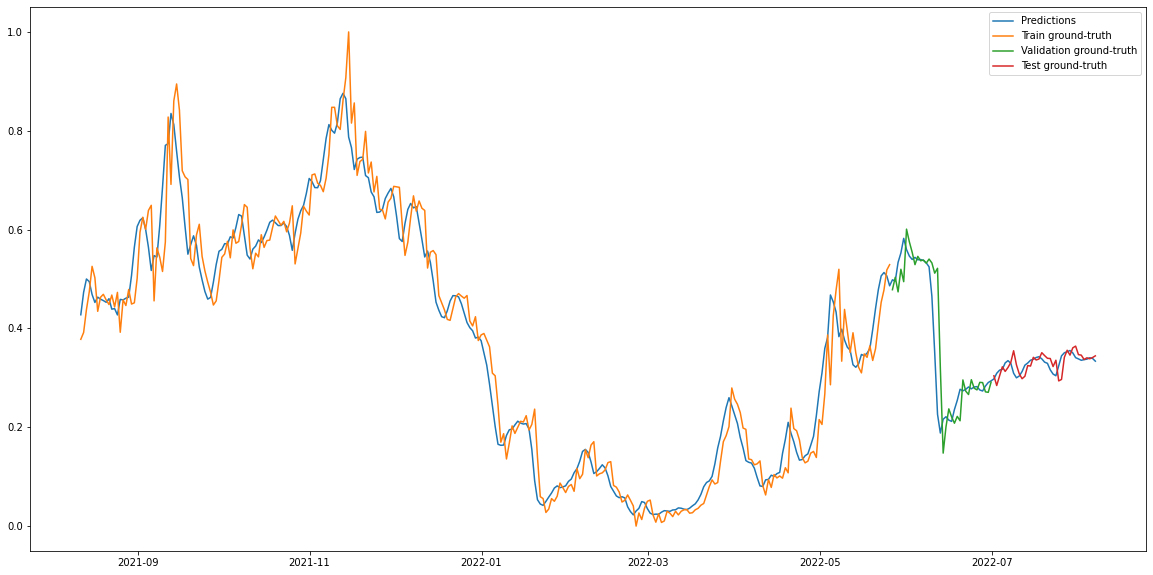

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dates, model.predict(X).flatten())
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Predictions','Train ground-truth','Validation ground-truth','Test ground-truth'])


2


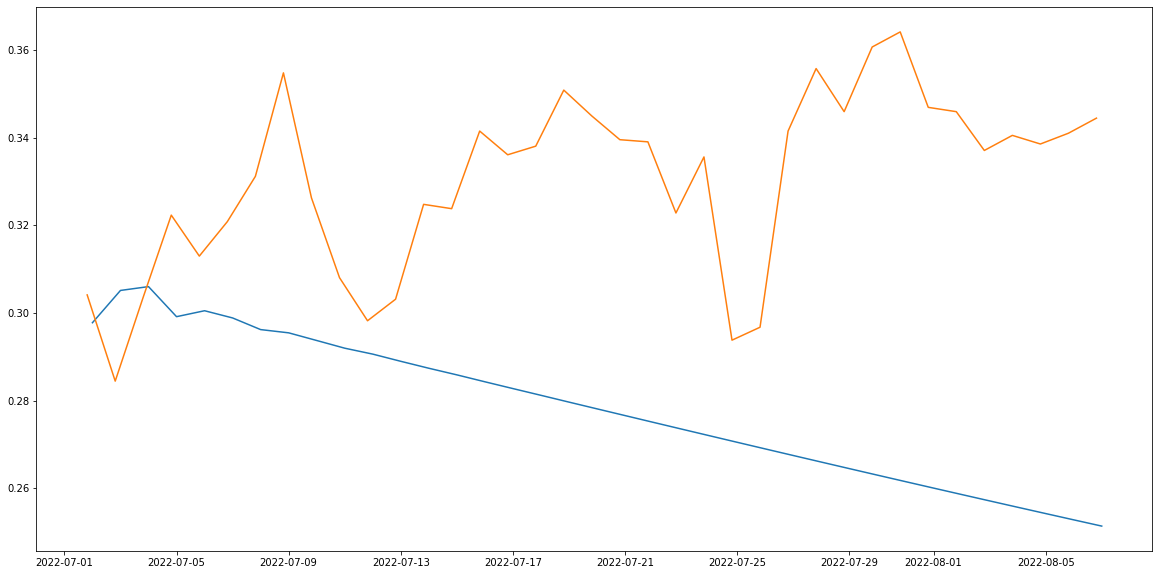

In [ ]:
year, month, day = str(dates[q_90]).split(' ')[0].split('-')
year, month, day = int(year), int(month), int(day)
next_day = datetime.datetime(year,month,day+1)
new_dates = np.array([])
new_y = np.array([])
new_X = X[q_90-1:q_90+1]
print(len(new_X))
for i in range(37):
  last_X = new_X[-1]
  predicted = model.predict((new_X[-2:,:,:])).flatten()
  new_y = np.append(new_y,predicted[1])
  new_X_item = np.array([[last_X[-2][0], last_X[-1][0], predicted[1]]]).reshape(1,3,1)
  new_X = np.append(new_X,new_X_item, axis=0)
  new_dates = np.append(new_dates,next_day)
  next_day = next_day + datetime.timedelta(days=1)

plt.figure(figsize=(20,10))
plt.plot(new_dates,new_y)
plt.plot(dates_test, y_test)

2


IndexError: ignored

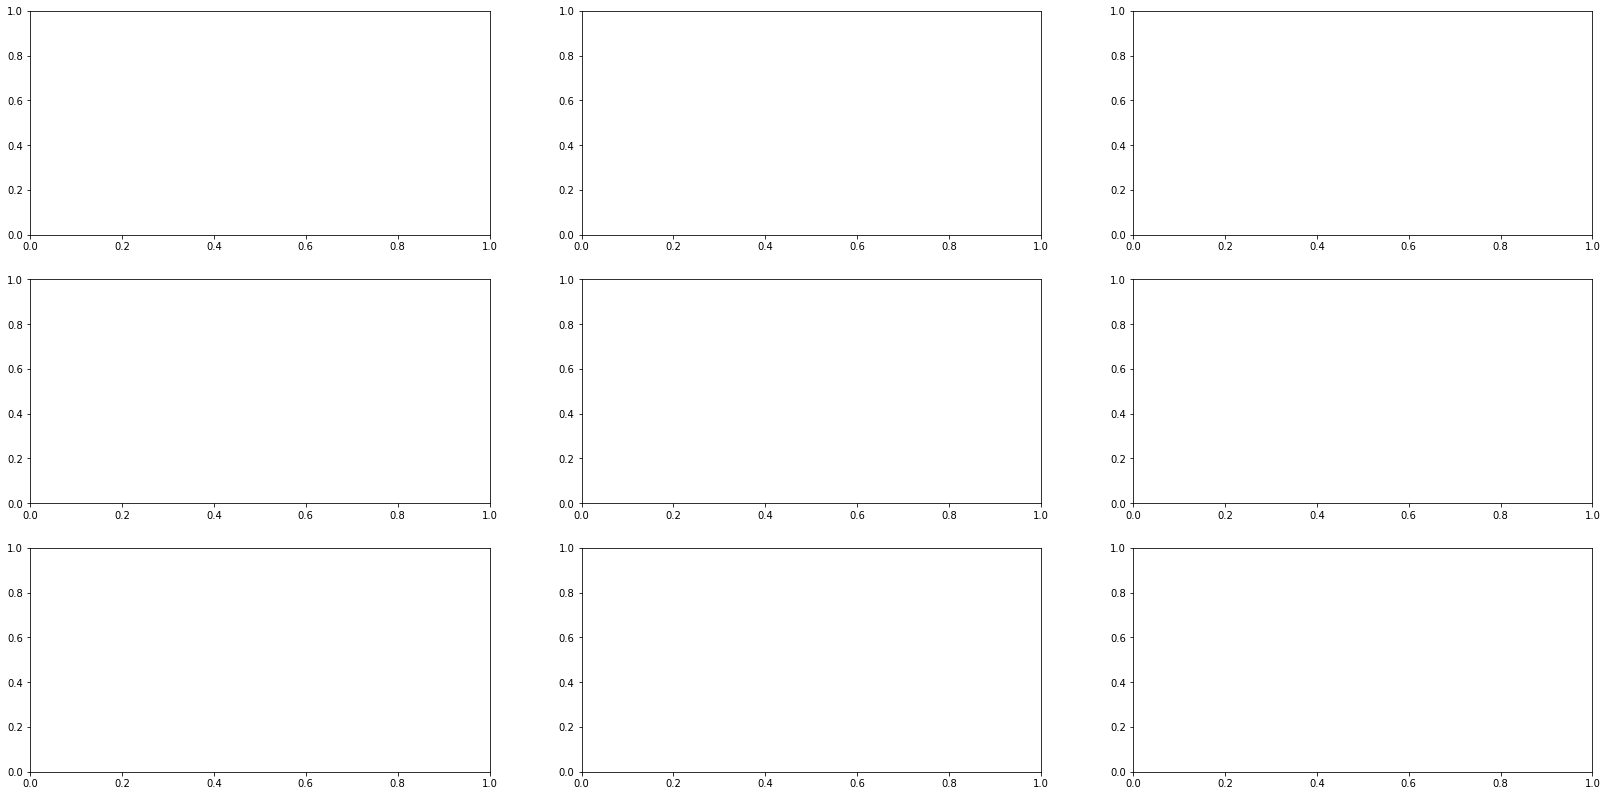

In [ ]:
## TODO:: declare a function for interpolation instead of doing it by hard codding.

a = -17
b= -15

signals_list = {}

fig = plt.figure(figsize=(28,14))
axes = fig.subplots(nrows=3,ncols=3)
for index, dataset in enumerate(datasets_splited):
  test_dataset = dataset['test']
  last_hour = test_dataset['dates'][b].time().hour
  y_pred = models[index].predict(test_dataset['X'][a:b]).flatten()
  y_actual = test_dataset['y'][a:b]
  ax = axes[int(index/3)][index%3]
  
  x = np.array([])
  y_sampled_pred = np.array([])
  y_sampled_actual = np.array([])
  print(last_hour)
  for i in range(last_hour):
    new_x = np.linspace(i,i+1,num=20)[:-1]
    new_y_actual = np.linspace(y_actual[a+i],y_actual[a+i+1],num=20)[:-1]
    new_y_pred = np.linspace(y_pred[a+i],y_pred[a+i+1],num=20)[:-1]

    x = np.append(x,new_x)
    y_sampled_pred = np.append(y_sampled_pred,new_y_pred)
    y_sampled_actual = np.append(y_sampled_actual,new_y_actual)
  
  ax.plot(x,y_sampled_pred)
  ax.plot(x,y_sampled_actual)
  #ax.plot(dataset['test']['dates'][a:], y_actual)
  ax.legend(['Test Predictions','Test Observations'])
  ax.set_title(cryptoes[index]['symbol'])

  idx = np.argwhere(np.diff(np.sign(y_sampled_actual - y_sampled_pred))).flatten()
  ax.plot(x[idx], y_sampled_actual[idx], 'ro')

  signals = []

  for id in idx:
    hour = int(x[id])
    minutes  = int(float((x[id] - int(x[id])) * 60 ))
    time = f'{hour}:{minutes}'
    if y_sampled_actual[id] < y_sampled_actual[id+1]:
      signals.append({'type':'buy','time':time,'idx':id, 'price':y_sampled_actual[id]})
    elif y_sampled_actual[id] > y_sampled_actual[id+1]:
      signals.append({'type':'sell','time':time,'idx':id, 'price':y_sampled_actual[id]})
  signals_list[cryptoes[index]['symbol']] = signals





